In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
from pylab import rcParams
import re

from bokeh.io import output_notebook
from bokeh.sampledata import us_states
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool, Range1d

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale


df_ag = pd.read_csv('C:/Users/sanfr/Desktop/ML_Prj/Datasets/in_use/Opioid_Age_Groups.csv')
df_s = pd.read_csv('C:/Users/sanfr/Desktop/ML_Prj/Datasets/in_use/Opioid_Summary.csv')
#print(df_ag.head(5))
print("df_ag (row, column):", df_ag.shape)
print(df_ag.describe())
#print(df_s.head(5))
print("df_s (row, column):", df_s.shape)
print(df_s.describe())

df_ag (row, column): (40964, 29)
               Year     FIPS Code          Rate  \
count  40964.000000  40964.000000  40964.000000   
mean    2014.000000  51263.992481     20.035336   
std        2.000024    270.862299     66.759621   
min     2011.000000  51001.000000      0.000000   
25%     2012.000000  51069.000000      0.000000   
50%     2014.000000  51139.000000      0.000000   
75%     2016.000000  51550.000000      6.300000   
max     2017.000000  51840.000000   2832.000000   

       VDH Health District Case Rate  VDH Health Region Case Rate  \
count                   40964.000000                 40964.000000   
mean                       19.238422                    19.681891   
std                        48.141090                    39.643513   
min                         0.000000                     0.000000   
25%                         0.000000                     0.000000   
50%                         1.700000                     4.200000   
75%                     

In [2]:
# Notes of Datasets:
# In total two datasets are used. one is 'Opioid_Summary',
# the other one is 'Opioid_Age_Groups'.
# We need both of them for two reasons:
# 1) Opioid_Summary doesn't have column 'Age Group', which cut
# the samples of each county into seven different age groups, 
# and describe the Case Count and Rate of each one.
# 2) Although Opioid_Age_Groups brings us more detailed statistics,
# it fails to show the Case Count and Rate of all age groups combined.
# However some times Opioid_Summary is not able to give us exact
# numbers on the Case Count (they use * instead). It is for the reason
# that the Case Count is smaller than 5. But, anyway, we still need 
# this dataset because we need to know the general Case Count and Rate
# of one county despite its' age groups.

# The description above is the main difference between our two datasets.
# We have examined the dataset, and we found out that the data are highly
# aligned, which means we will be using Opioid_Age_Groups most of the time,
# and Opioid_Summary will be used only when we need the Case Count and Rate
# of one county's all_age_groups. Since the data in two datasets are highly
# aligned, we can get the value of 'all_age_groups' easily by using the 
# index from 'Opioid_Age_Groups' ('Year', 'Locality', etc.).

# In the following Section, we will describe the features of these datasets
# in X Parts. Since the dataset 'Opioid_Summary' only provides the Case Count
# and Rate of one county's all_age_groups, we will omit this part, and mainly
# describe the other important features and index.

In [3]:
# Section I Dataset Properties
# Part 1 --- Column 1: 'Year'
print("The dataset covers Virginia's Opioid Addiction data from 2011 to 2017.\n" \
      "For each year, they have data detailed to the Case Count and Rate of " \
      "each Type of case (8 types in total) in each county (133 counties in total)." \
      " Thus, we have 133*8 = 1064 rows of Case Count and Rate data for every year " \
      "recorded in the dataset 'Opioid_Summary'. Since we have 7 different age groups " \
      "for 6 of 8 kind of Types, and two of them ('NAS' and 'HCV') only have one " \
      "class of age_groups (0-18, 18-30, respectively). So, the data here in " \
      "'Opioid_Age_Groups' is expanded to 133*(7*6+1*2) = 5852 rows per year. \n" \
      "the follings shows the data grouped by the index 'Year'.\n")

grp_1ag = df_ag.groupby('Year').groups
print("catagory 'Year' in df_ag:")
grp_1ag

The dataset covers Virginia's Opioid Addiction data from 2011 to 2017.
For each year, they have data detailed to the Case Count and Rate of each Type of case (8 types in total) in each county (133 counties in total). Thus, we have 133*8 = 1064 rows of Case Count and Rate data for every year recorded in the dataset 'Opioid_Summary'. Since we have 7 different age groups for 6 of 8 kind of Types, and two of them ('NAS' and 'HCV') only have one class of age_groups (0-18, 18-30, respectively). So, the data here in 'Opioid_Age_Groups' is expanded to 133*(7*6+1*2) = 5852 rows per year. 
the follings shows the data grouped by the index 'Year'.

catagory 'Year' in df_ag:


{2011: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             5842, 5843, 5844, 5845, 5846, 5847, 5848, 5849, 5850, 5851],
            dtype='int64', length=5852),
 2012: Int64Index([ 5852,  5853,  5854,  5855,  5856,  5857,  5858,  5859,  5860,
              5861,
             ...
             11694, 11695, 11696, 11697, 11698, 11699, 11700, 11701, 11702,
             11703],
            dtype='int64', length=5852),
 2013: Int64Index([11704, 11705, 11706, 11707, 11708, 11709, 11710, 11711, 11712,
             11713,
             ...
             17546, 17547, 17548, 17549, 17550, 17551, 17552, 17553, 17554,
             17555],
            dtype='int64', length=5852),
 2014: Int64Index([17556, 17557, 17558, 17559, 17560, 17561, 17562, 17563, 17564,
             17565,
             ...
             23398, 23399, 23400, 23401, 23402, 23403, 23404, 23405, 23406,
             23407],
            dtype='int64', length=5852),
 2015: Int64Index(

In [4]:
grp_1s = df_s.groupby('Year').groups
print("\n\ncatagory 'Year' in df_s:")
grp_1s



catagory 'Year' in df_s:


{2011: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063],
            dtype='int64', length=1064),
 2012: Int64Index([1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073,
             ...
             2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127],
            dtype='int64', length=1064),
 2013: Int64Index([2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137,
             ...
             3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191],
            dtype='int64', length=1064),
 2014: Int64Index([3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201,
             ...
             4246, 4247, 4248, 4249, 4250, 4251, 4252, 4253, 4254, 4255],
            dtype='int64', length=1064),
 2015: Int64Index([4256, 4257, 4258, 4259, 4260, 4261, 4262, 4263, 4264, 4265,
             ...
             5310, 5311, 5312, 5313, 5314, 5315, 5316, 5317,

In [5]:
# Part 2 --- Column 2 & 3: 'FIPS Code' & 'Locality'
print("There are in total 133 counties here in Virginia, and each of them " \
      "is shown under the index 'Locality', and each of them has its unique " \
      "FIPS Code. For details, refer to the follows.\n" \
      "Their relations are described below as\n {('Locality','FIPS Code'): " \
      "Length = count_of_rows_under_this_Locality.}\n")

grp_2 = df_ag.groupby(['Locality', 'FIPS Code']).groups
print("Count of ('Locality', 'FIPS Code'): ", len(grp_2))
grp_2

There are in total 133 counties here in Virginia, and each of them is shown under the index 'Locality', and each of them has its unique FIPS Code. For details, refer to the follows.
Their relations are described below as
 {('Locality','FIPS Code'): Length = count_of_rows_under_this_Locality.}

Count of ('Locality', 'FIPS Code'):  133


{('Accomack',
  51001): Int64Index([    0,   133,   266,   399,   532,   665,   798,   931,  1064,
              1197,
             ...
             39634, 39767, 39900, 40033, 40166, 40299, 40432, 40565, 40698,
             40831],
            dtype='int64', length=308),
 ('Albemarle',
  51003): Int64Index([    1,   134,   267,   400,   533,   666,   799,   932,  1065,
              1198,
             ...
             39635, 39768, 39901, 40034, 40167, 40300, 40433, 40566, 40699,
             40832],
            dtype='int64', length=308),
 ('Alexandria',
  51510): Int64Index([   95,   228,   361,   494,   627,   760,   893,  1026,  1159,
              1292,
             ...
             39729, 39862, 39995, 40128, 40261, 40394, 40527, 40660, 40793,
             40926],
            dtype='int64', length=308),
 ('Alleghany',
  51005): Int64Index([    2,   135,   268,   401,   534,   667,   800,   933,  1066,
              1199,
             ...
             39636, 39769, 39902, 40035, 

In [6]:
# Part 3 --- Column 4 & 5: 'Source' & 'Type'
print("There are in total 6 kinds of 'Source', and 8 kinds of 'Type'.\n" \
      "Their relations are described below as\n {('Source','Type'): " \
      "Length = count_of_rows_under_this_type.}\n" \
     "To be noted, under 'HCV' and 'NAS', they only have one age group each, " \
     "so the length of them is different from other types.\n")

#print(df_ag.groupby('Source').groups)
#print("\n\n")
#print(df_ag.groupby('Type').groups)
grp_3 = df_ag.groupby(['Source', 'Type']).groups
print("Count of ('Source','Type'): ", len(grp_3))
grp_3

There are in total 6 kinds of 'Source', and 8 kinds of 'Type'.
Their relations are described below as
 {('Source','Type'): Length = count_of_rows_under_this_type.}
To be noted, under 'HCV' and 'NAS', they only have one age group each, so the length of them is different from other types.

Count of ('Source','Type'):  8


{('ED',
  'ED Heroin Overdose'): Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                 9,
             ...
             36033, 36034, 36035, 36036, 36037, 36038, 36039, 36040, 36041,
             36042],
            dtype='int64', length=6517),
 ('ED',
  'ED Opioid Overdose'): Int64Index([  931,   932,   933,   934,   935,   936,   937,   938,   939,
               940,
             ...
             36964, 36965, 36966, 36967, 36968, 36969, 36970, 36971, 36972,
             36973],
            dtype='int64', length=6517),
 ('EMS',
  'EMS Narcan'): Int64Index([ 1862,  1863,  1864,  1865,  1866,  1867,  1868,  1869,  1870,
              1871,
             ...
             37895, 37896, 37897, 37898, 37899, 37900, 37901, 37902, 37903,
             37904],
            dtype='int64', length=6517),
 ('HCV',
  'Reported Hepatitis C (18-30 year olds)'): Int64Index([ 2793,  2794,  2795,  2796,  2797,  2798,  2799,  2800,  2801,
              2802,
         

# Part 4 --- Column 6-8: 'Age Group', 'Case Count' and 'Rate'
This part is arguably the most interesting and important part of this whole dataset. To understand it better, there are a few things we need to know about it first.
First of all, not all Case Count have valid numerical data. Some of them only has a '*' as the value, which means the case count in it is between 0 and 5. The dataset description stated that 'it is for maintaining the confidentiality and accurate rate calculations'.
Secondly, due to the data availability of different years, we found the following data not available:
 1) all data under 'Source == ED' from year 2011 to 2014.
 2) all data under 'Source == NAS' in year 2017.
For more specific descriptions, 'Case Count' shows the count of each case happened during this specific 'Year', at this particular county, under this certain 'Age Group', and the case is categorized under this 'Source' and 'Type'. So basically, each 'Case Count' and 'Rate' corresponding to a certain ('Year','FIPS Code','Type','Age Group') condition.
The 'Case Count' and 'Rate' has slightly different meanings for different 'Source' and 'Types', the description can be seen from the following chart:

In [7]:
# Part 4 --- Column 6-8: 'Age Group', 'Case Count' and 'Rate'

print("if 'Source'=='ED',")
print("\t'Case Count' means 'ED Visit Count'," \
        " 'Rate' means 'Visit Rate'")
print("if 'Source'=='EMS',")
print("\t'Case Count' means 'EMS Narcan Administrations'," \
        " 'Rate' means 'Administration Rate'")
print("if 'Source'=='HCV',")
print("\t'Case Count' means 'New Reported Hepatitis C Case Count'," \
        " 'Rate' means 'New Case Rate'")
print("if 'Source'=='HIV',")
print("\t'Case Count' means 'New Diagnosed HIV Case Count'," \
        " 'Rate' means 'New Case Rate'")
print("if 'Source'=='NAS',")
print("\t'Case Count' means 'New Diagnosed NAS Case Count'," \
        " 'Rate' means 'New Case Rate'")
print("if 'Source'=='OD Death',")
print("\t'Case Count' means 'Death Count'," \
        " 'Rate' means 'Mortality Rate'\n")


print("\nfor this part, we don't have any code demo yet.")
print("\nfor Qian and Onyi, if u wonder what is Narcan, \n" \
      "\tcheck https://www.youtube.com/watch?v=RL4-Umip_Cc. \n" \
      "I have no idea what that is, but looks cool :)\n" \
      "if u wonder what is NAS, \n" \
      "\tit is called Neonatal Abstinence Syndrome,\nwhich is " \
      "generally a health issue for new borns whose mothers " \
      "have used opioid when they are pregnant. \n"
      "I'm not sure if we need to clear these terms to the "\
      "audience, but i guess we need to know about it for sure.\n" \
      "remember to let me know u guys opinions :)")



if 'Source'=='ED',
	'Case Count' means 'ED Visit Count', 'Rate' means 'Visit Rate'
if 'Source'=='EMS',
	'Case Count' means 'EMS Narcan Administrations', 'Rate' means 'Administration Rate'
if 'Source'=='HCV',
	'Case Count' means 'New Reported Hepatitis C Case Count', 'Rate' means 'New Case Rate'
if 'Source'=='HIV',
	'Case Count' means 'New Diagnosed HIV Case Count', 'Rate' means 'New Case Rate'
if 'Source'=='NAS',
	'Case Count' means 'New Diagnosed NAS Case Count', 'Rate' means 'New Case Rate'
if 'Source'=='OD Death',
	'Case Count' means 'Death Count', 'Rate' means 'Mortality Rate'


for this part, we don't have any code demo yet.

for Qian and Onyi, if u wonder what is Narcan, 
	check https://www.youtube.com/watch?v=RL4-Umip_Cc. 
I have no idea what that is, but looks cool :)
if u wonder what is NAS, 
	it is called Neonatal Abstinence Syndrome,
which is generally a health issue for new borns whose mothers have used opioid when they are pregnant. 
I'm not sure if we need to clear these 

# Part 5 --- Column 9-29: Several Regional Statistical Index
This part is basically the statistical results of each region of Virginia. Firstly, we need to split these twenty one columns into seven parts, according to the regional index. First of all, in column 8, 11, 14, 17, 20, 23, and 26, (column H, K, N, Q, T, W and Z, in Excel file, respectively), we can find regional index such as 'VDH Health District', 'VDH Health Region', and 'Police Division'. Each of these index devide the whole State into several administrative regions/divisions, and we can see the counties fall into these administrative regions, and these regions has the accumulated statistics shown in their 'Case Counts' and 'Rates'.
It should be noted, that each county only belongs to one and only region/devision in each regional index, and, although the counties often fall into the same term under different regional index, for example, Albemarle is categrized under 'Northwest' in both 'VDH Health Region' 'Va H&H Preparedness Region' index, other counties may not share the same situation (i.e., Caroline (51033)). More detailed comparisons can be found in next Part.
In the following part, we print out the categories in each regional index:

In [8]:
# Part 5 --- Column 9-29: Several Regional Statistical Index

print("VDH Health District:")
grp_5H = df_ag.groupby(['VDH Health District']).groups
print("Count of 'VDH Health District': ", len(grp_5H))
#print(grp_5H)
print("\nVDH Health Region:")
grp_5K = df_ag.groupby(['VDH Health Region']).groups
print("Count of 'VDH Health Region': ", len(grp_5K))
#print(grp_5K)
print("\nVA H&H Preparedness Region:")
grp_5N = df_ag.groupby(['Virginia Hospital & Healthcare Preparedness Region']).groups
print("Count of 'VA H&H Preparedness Region': ", len(grp_5N))
#print(grp_5N)
print("\nVA DoE Management Region:")
grp_5Q = df_ag.groupby(['Virginia Department of Emergency Management Region']).groups
print("Count of 'VA DoE Management Region': ", len(grp_5Q))
#print(grp_5Q)
print("\nCommunity Service Board:")
grp_5T = df_ag.groupby(['Community Service Board']).groups
print("Count of 'Community Service Board': ", len(grp_5T))
#print(grp_5T)
print("\nVA State Police Division:")
grp_5W = df_ag.groupby(['Virginia State Police Division']).groups
print("Count of 'VA State Police Division': ", len(grp_5W))
#print(grp_5W)
print("\nVirginia State:")
grp_5Z = df_ag.groupby(['Virginia State']).groups
print("Count of 'Virginia State': ", len(grp_5Z))
#print(grp_5Z)

VDH Health District:
Count of 'VDH Health District':  35

VDH Health Region:
Count of 'VDH Health Region':  5

VA H&H Preparedness Region:
Count of 'VA H&H Preparedness Region':  6

VA DoE Management Region:
Count of 'VA DoE Management Region':  7

Community Service Board:
Count of 'Community Service Board':  40

VA State Police Division:
Count of 'VA State Police Division':  7

Virginia State:
Count of 'Virginia State':  1


# Part 6 --- Examples of Comparisons Mentioned in Part 5 
In this part, we offer two examples of how different counties can fall into the same/different regional index which share the same term for two unrelated categories.

In [9]:
# Part 6 --- Examples of Comparisons Mentioned in Part 5 
print("Example 1: counties share the same catagories under " \
      "regional index 'VDH Health District', 'VDH Health Region', "\
      "'Va H&H Preparedness Region', 'Community Service Board', "\
      "and 'VA State Police Division'.\n")

df_6a1 = df_s.query("Year == 2017 & Source == 'HIV'")
loc_name = ['Charlottesville', 'Nelson', 'Albemarle'] 
df_6a = df_6a1.query("Locality in @loc_name")
df_6a

Example 1: counties share the same catagories under regional index 'VDH Health District', 'VDH Health Region', 'Va H&H Preparedness Region', 'Community Service Board', and 'VA State Police Division'.



,Year,FIPS Code,Locality,Source,Type,Case Count Display,Rate,VDH Health District,VDH Health District Case Count Display,VDH Health District Case Rate,...,Virginia Department of Emergency Management Region Case Rate,Community Service Board,Community Service Board Case Count Display,Community Service Board Case Rate,Virginia State Police Division,Virginia State Police Division Case Count Display,Virginia State Police Division Case Rate,Virginia State,Virginia State Case Count Display,Virginia State Case Rate
6917,2017,51003,Albemarle,HIV,Diagnosed HIV,10,9.4,Thomas Jefferson,16,6.4,...,6.2,Region Ten Community Services Board,16,6.4,VSP Division 3,43,6.5,Virginia State,894,10.6
6976,2017,51125,Nelson,HIV,Diagnosed HIV,0,0.0,Thomas Jefferson,16,6.4,...,6.2,Region Ten Community Services Board,16,6.4,VSP Division 3,43,6.5,Virginia State,894,10.6
7014,2017,51540,Charlottesville,HIV,Diagnosed HIV,*,6.4,Thomas Jefferson,16,6.4,...,6.2,Region Ten Community Services Board,16,6.4,VSP Division 3,43,6.5,Virginia State,894,10.6


In [10]:
print("\nExample 2: counties share the same catagories under " \
      "one regional index may or may not share the same " \
      "catagory under another regional index.\n")

df_6b1 = df_s.query("Year == 2017 & Source == 'HIV'")
loc_name = ['Manassas City', 'Caroline', 'King George', 'Rockingham']

df_6b = df_6b1.query("Locality in @loc_name")
df_6b


Example 2: counties share the same catagories under one regional index may or may not share the same catagory under another regional index.



,Year,FIPS Code,Locality,Source,Type,Case Count Display,Rate,VDH Health District,VDH Health District Case Count Display,VDH Health District Case Rate,...,Virginia Department of Emergency Management Region Case Rate,Community Service Board,Community Service Board Case Count Display,Community Service Board Case Rate,Virginia State Police Division,Virginia State Police Division Case Count Display,Virginia State Police Division Case Rate,Virginia State,Virginia State Case Count Display,Virginia State Case Rate
6932,2017,51033,Caroline,HIV,Diagnosed HIV,*,9.9,Rappahannock,21,5.8,...,4.7,Rappahannock Area Community Services Board,21,5.8,VSP Division 1,210,14.8,Virginia State,894,10.6
6964,2017,51099,King George,HIV,Diagnosed HIV,*,11.5,Rappahannock,21,5.8,...,4.7,Rappahannock Area Community Services Board,21,5.8,VSP Division 1,210,14.8,Virginia State,894,10.6
6994,2017,51165,Rockingham,HIV,Diagnosed HIV,*,2.5,Central Shenandoah,10,3.4,...,6.2,Harrisonburg-Rockingham Community Services Board,5,3.8,VSP Division 2,38,4.5,Virginia State,894,10.6
7030,2017,51683,Manassas City,HIV,Diagnosed HIV,*,2.4,Prince William,58,11.3,...,9.1,Prince William County Community Services Board,58,11.3,VSP Division 7,227,9.2,Virginia State,894,10.6


In [11]:
# Section II Plotting and Discovering
# Part 1 --- Filter the Datasets
# Check and Remove NULL Data
print("-Is there any NaN values in O_A_G? -", df_ag.isnull().values.any())
print("-Is there any NaN values in O_S? -", df_s.isnull().values.any())
df_ag.isnull().sum()
df_ag = df_ag.dropna(how='any',axis=0)

# Check Rate correlations
corr = df_ag.corr()
print("Check Rate Correlations:\n", corr["Rate"].sort_values(ascending = False))

# Lable Encoding
lable_feat_ag = df_ag.loc[:,:].values
lable_feat_s = df_s.loc[:,:].values
lable_feat_s10 = df_s.loc[:,:].values
#print(lable_feat_ag)
#print("before lable_feat_ag:\n", df_ag.head(5))

lable_enc = LabelEncoder()
# 3:Source, 4:Type, 5:Age Group
#lable_feat_ag[:,3] = lable_enc.fit_transform(lable_feat_ag[:,3])
#lable_feat_ag[:,4] = lable_enc.fit_transform(lable_feat_ag[:,4])
#lable_feat_ag[:,5] = lable_enc.fit_transform(lable_feat_ag[:,5])
lable_feat_s[:,22] = lable_enc.fit_transform(lable_feat_s[:,22])

lable_feat_s10[:,10] = lable_enc.fit_transform(lable_feat_s[:,10])
ds_s_enc10 = pd.DataFrame(lable_feat_s10)

ds_ag_enc = pd.DataFrame(lable_feat_ag)
ds_s_enc = pd.DataFrame(lable_feat_s)
#print("after lable_ag_enc:\n", lable_feat_ag)
print("after lable_enc:\n")
print("ds_ag_enc (row, column):", ds_ag_enc.shape)
print("ds_s_enc (row, column):", ds_s_enc.shape)
ds_ag_enc.head(5)
ds_s_enc.head(5)

-Is there any NaN values in O_A_G? - False
-Is there any NaN values in O_S? - False
Check Rate Correlations:
 Rate                                                            1.000000
Community Service Board Case Rate                               0.756001
VDH Health District Case Rate                                   0.742062
Virginia State Police Division Case Rate                        0.696062
Virginia Department of Emergency Management Region Case Rate    0.693922
Virginia Hospital & Healthcare Preparedness Region Case Rate    0.681504
VDH Health Region Case Rate                                     0.637624
Virginia State Case Rate                                        0.586437
Year                                                            0.150140
FIPS Code                                                       0.035187
Name: Rate, dtype: float64
after lable_enc:

ds_ag_enc (row, column): (40964, 29)
ds_s_enc (row, column): (7448, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,2011,51001,Accomack,ED,ED Heroin Overdose,0,0,Eastern Shore,0,0,...,0,Eastern Shore Community Services Board,0,0,4,0,0,Virginia State,0,0
1,2011,51003,Albemarle,ED,ED Heroin Overdose,0,0,Thomas Jefferson,0,0,...,0,Region Ten Community Services Board,0,0,2,0,0,Virginia State,0,0
2,2011,51005,Alleghany,ED,ED Heroin Overdose,0,0,Alleghany,0,0,...,0,Alleghany Highlands Community Services Board,0,0,5,0,0,Virginia State,0,0
3,2011,51007,Amelia,ED,ED Heroin Overdose,0,0,Piedmont,0,0,...,0,Crossroads Community Services Board,0,0,0,0,0,Virginia State,0,0
4,2011,51009,Amherst,ED,ED Heroin Overdose,0,0,Central Virginia,0,0,...,0,Horizon Behavioral Health,0,0,2,0,0,Virginia State,0,0


In [12]:
# Part 2 data visualizing
# 2.1 Basic Filters

# Year_filter for column 0
    # 2011-2017.
    # when year is in 2011-2014, Source can't be ED.
    # when year is 2017, Source can't be NAS.
Year_flt = [2017]

# Source filter for column 3
    # ED, EMS, HCV, HIV, NAS, OD Death
Src_flt = []

# Type filter for column 4
    # Diagnosed HIV
    # ED Heroin Overdose
    # ED Opioid Overdose
    # EMS Narcan
    # Fatal Fentanyl and/or Heroin Overdose,
    # Fatal Prescription Opioid Overdose,
    # Neonatal Abstinance Syndrome
    # Reported Hepatitis C (18-30 year olds)
Type_flt = []

# Age Group filter for column 5
    # 0-14, 15-24, 25-34, 35-44, 45-54, 55-64, 65+
    # 18-30 (for HCV only)
Type_flt = []

# Virginia State statistics at column 26


In [13]:
# Part 2 data visualizing
# 2.2 Regional Filters

# 'VDH Health Region' filter for column 11
    # 'Central', 'Eastern', 'Northern', 'Northwest', 'Southwest'
VHR_flt = ['Central', 'Eastern', 'Northern', 'Northwest', 'Southwest']

# 'Virginia Hospital & Healthcare Preparedness Region' filter for column 14
    # 'Central', 'Eastern', 'Northern', 'Northwest',
    # 'Far Southwest', 'Near Southwest'
VPR_flt = []

# 'Locality' filter for column 2
Cty_flt = ['Albemarle']

# 'VDH Health District' filter for column 8
VHD_flt = []

# 'Virginia Department of Emergency Management Region' filter for column 17
    # 'Central Virginia', 'Culpeper', 'Northern Virginia',
    # 'Richmond', 'Roanoke Area', 'Southwest', 'Tidewater'
VMR_flt = []

# 'Community Service Board' filter for column 20
CSB_flt = []

# 'Virginia State Police Division' filter for column 23
    # VSP Division 1~7
VPD_flt = ['VSPD1', 'VSPD2', 'VSPD3', 'VSPD4', 'VSPD5', 'VSPD6', 'VSPD7']

In [14]:
# Part 2 data visualizing
# 2.3 Plotting
import webcolors as wclr
import random
import plotly.plotly as pltly
import plotly.figure_factory as ff

# 2.3.1 random color generator
def random_colors(n):
    ret = []
    r = int(random.random() * 256)
    g = int(random.random() * 256)
    b = int(random.random() * 256)
    step = 256 / n
    for i in range(n):
        r += step
        g += step
        b += step
        r = int(r) % 256
        g = int(g) % 256
        b = int(b) % 256
        cl = wclr.rgb_to_hex([r, g, b])
        ret.append(cl) 
    return ret


# 2.3.2 multiple line plot generator
def multilineplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title):
    for i in range(0, len(y_data_list)):
        plt.plot(x_data, y_data_list[i], color = colors[i], label=y_data_names[i], markersize=12,  linewidth=4)
        #linestyle='dashed'
    plt.ylabel(y_label)
    plt.xticks(x_data, x_names, fontweight='bold')
    plt.xlabel(x_label)
    plt.title(title)
    plt.legend(loc = 'upper left')
    plt.rcParams['figure.dpi'] = 240
    

# 2.3.3 grouped bar plot generator
def groupedbarplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title):
    _, ax = plt.subplots()
    # Total width for all bars at one x location
    total_width = 0.8
    # Width of each individual bar
    ind_width = total_width / len(y_data_list)
    # This centers each cluster of bars about the x tick mark
    alteration = np.arange(-(total_width/2), total_width/2, ind_width)

    # Draw bars, one category at a time
    for i in range(0, len(y_data_list)):
        # Move the bar to the right on the x-axis so it doesn't
        # overlap with previously drawn ones
        plt.bar(x_data + alteration[i], y_data_list[i], color = colors[i], label = y_data_names[i], width = ind_width)
    plt.ylabel(y_label)
    plt.xticks(x_data, x_names, fontweight='bold')
    plt.xlabel(x_label)
    plt.title(title)
    plt.legend(loc = 'upper right')
    plt.rcParams['figure.dpi'] = 240
    

# 2.3.4 stacked bar plot generator
def stackedbarplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title):
    _, ax = plt.subplots()
    # Draw bars, one category at a time
    i = 0
    bars_height = 0
    for i in range(0, len(y_data_list)):
        if i == 0:
            plt.bar(x_data, y_data_list[i], color = colors[i], align = 'center', label = y_data_names[i])
        else:
            # For each category after the first, the bottom of the
            # bar will be the top of the last category
            bars_height += np.asarray(y_data_list[i-1])
            plt.bar(x_data, y_data_list[i], color = colors[i], bottom = bars_height, align = 'center', label = y_data_names[i])
    plt.ylabel(y_label)
    plt.xticks(x_data, x_names, fontweight='bold')
    plt.xlabel(x_label)
    plt.title(title)
    plt.legend(loc = 'upper right')
    plt.rcParams['figure.dpi'] = 240
    
# 2.3.5 choropleth map generator
def choropleth_map(x_data, y_data_list, title):
    # $ pip install plotly 
    # $pip install geopandas==0.3.0
    # $pip install pyshp==1.2.10
    # $pip install shapely==1.6.3
    # After installing the Plotly package, fire up python: 
    # $ python 
    # and set the credentials:
    # $ import plotly
    # $ plotly.tools.set_credentials_file(username='sanfrak', api_key='5hA2nFi7NuaoNmPAZbas')
    endpts = list(np.mgrid[min(y_data_list):max(y_data_list):5j])
    colorscale = ["#ffeaea","#ffbaba","#ff7575","#ff2b2b","#a50000","#490000"]
    fig = ff.create_choropleth(
        fips=x_data, values=y_data_list, scope=['Virginia'], show_state_data=True,
        colorscale=colorscale, binning_endpoints=endpts, round_legend_values=True,
        plot_bgcolor='rgb(229,229,229)',
        paper_bgcolor='rgb(229,229,229)',
        legend_title= title,
        county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
        
    )
    return fig;
    #pltly.iplot(fig, filename='choropleth_virginia')

In [15]:
# the following four cells are plottings. including:
# part1: Case Rates in VHR (multi_line_plot)
# part2: Case Rates by VSPD (group_bar_plot)
# part3: Case Count by VHR (stacked_bar_plot)
# part4: Case Rate by Age Group (group_bar_plot)
# part5: Case Rates by County (choropleth_map)

x_data:
 [2011, 2012, 2013, 2014, 2015, 2016, 2017]
y_data_list:
 [[70.2, 77.3, 73.5, 70.5, 102.6, 152.3, 160.5], [29.4, 38.8, 42.1, 42.6, 43.0, 87.2, 106.4], [19.0, 14.7, 18.1, 19.0, 30.2, 71.7, 67.3], [63.0, 77.7, 84.9, 88.4, 122.9, 183.6, 196.7], [138.0, 196.8, 210.8, 220.7, 217.4, 238.7, 243.7]]
the generated random colors:
 ['#797317', '#aca64a', '#dfd97d', '#120cb0', '#453fe3']


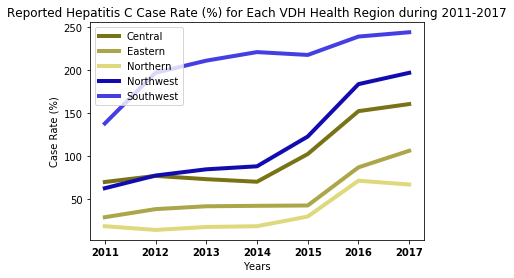

In [16]:
# part1: Case Rates in VHR (multi_line_plot)

df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc10
# In this part, we plot a graph that shows the case count rate of
# "Reported Hepatitis C (18-30 year olds)" from 2011 to 2017 in each health region.
# For this purpose, we need the following data:
# 1) x -> Year (from 2011 to 2017)
x_names = ["2011", "2012", "2013", "2014", "2015", "2016", "2017"]
x_data = sorted(df_plt2[0].unique())
print("x_data:\n", x_data)
# 2) y -> Rate (col: 12) of Virginia Health Region (col: 10)
    #   a) Name: column 10, Case Count: column 11, Rate: column 12
y_data_names = ['Central', 'Eastern', 'Northern', 'Northwest', 'Southwest']
    #   b) Specify the dataset is df_plt2, Rate (col:12), and Type=='Reported Hepatitis C' (col:4)
df_flt0 = (df_plt2[12])[df_plt2[4] == 'Reported Hepatitis C (18-30 year olds)']
    #   b) Extract Rate of each VHR each Year into matrix y_data_list[year][region]
y_data_list = []
# Caution! i-->Year; j-->VHR
for i in range (0, 4+1):  # 0~4 is VHR encoded names (col:10)
    df_flt1 = df_flt0[df_plt2[10] == i]
    j_data = []
    for j in range(2011, 2017+1):  # 2011-2017 is Year (col:0)
        df_flt2 = df_flt1[df_plt2[0] == j]
        rate = np.array(df_flt2)[0]
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "Years"
y_label = "Case Rate (%)"
title = "Reported Hepatitis C Case Rate (%) for Each VDH Health Region during 2011-2017"
# 5) Print plot
multilineplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)

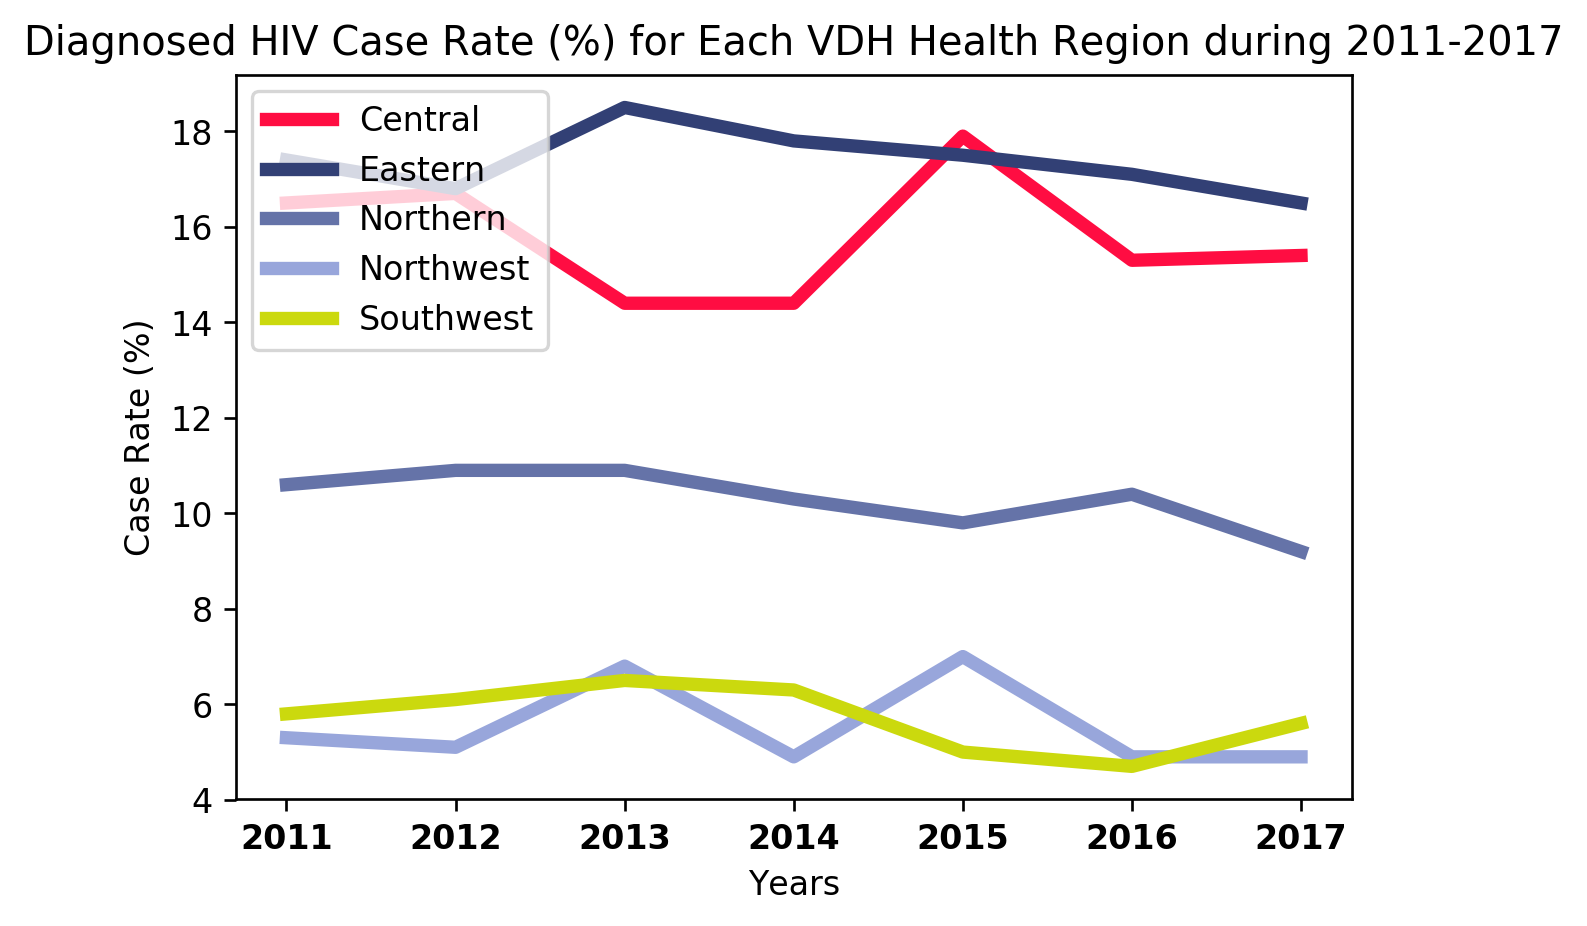

In [17]:
# Case Rate of Diagnosed HIV
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc10
# 1) x -> Year (from 2011 to 2017)
x_names = ["2011", "2012", "2013", "2014", "2015", "2016", "2017"]
x_data = sorted(df_plt2[0].unique())
#print("x_data:\n", x_data)
# 2) y -> Rate (col: 12) of Virginia Health Region (col: 10)
    #   a) Name: column 10, Case Count: column 11, Rate: column 12
y_data_names = ['Central', 'Eastern', 'Northern', 'Northwest', 'Southwest']
    #   b) Specify the dataset is df_plt2, Rate (col:12), and Type=='Diagnosed HIV' (col:4)
df_flt0 = (df_plt2[12])[df_plt2[4] == 'Diagnosed HIV']
    #   b) Extract Rate of each VHR each Year into matrix y_data_list[year][region]
y_data_list = []
# Caution! i-->Year; j-->VHR
for i in range (0, 4+1):  # 0~4 is VHR encoded names (col:10)
    df_flt1 = df_flt0[df_plt2[10] == i]
    j_data = []
    for j in range(2011, 2017+1):  # 2011-2017 is Year (col:0)
        df_flt2 = df_flt1[df_plt2[0] == j]
        rate = np.array(df_flt2)[0]
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
#print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
#print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "Years"
y_label = "Case Rate (%)"
title = "Diagnosed HIV Case Rate (%) for Each VDH Health Region during 2011-2017"
# 5) Print plot
multilineplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)

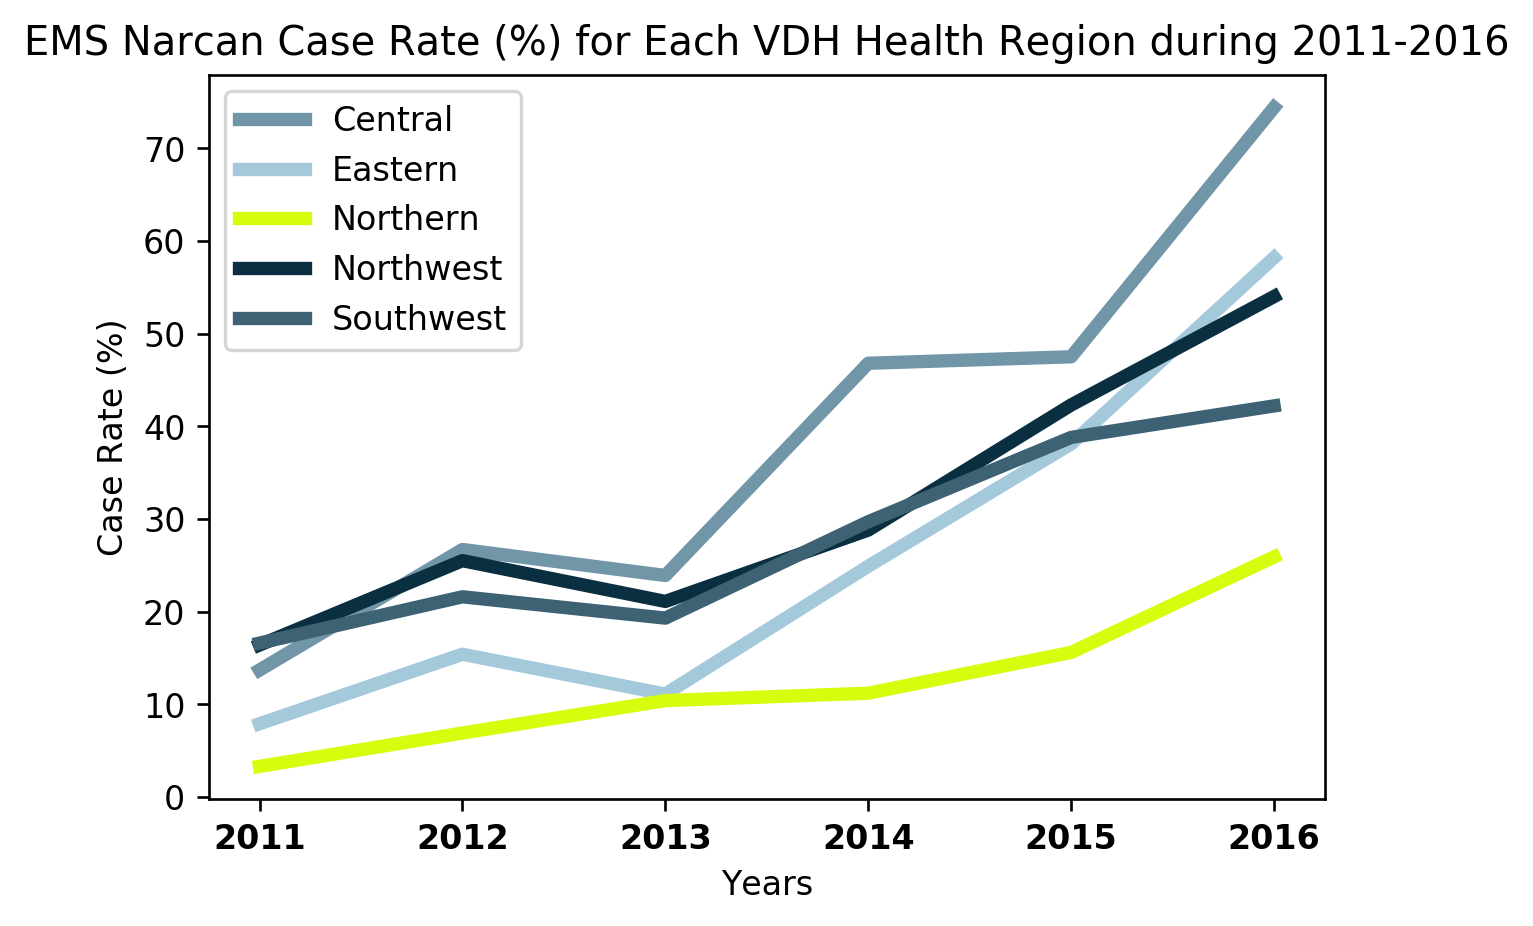

In [18]:
# Case Rate of EMS Narcan
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc10
# 1) x -> Year (from 2011 to 2016)
x_names = ["2011", "2012", "2013", "2014", "2015", "2016"]
x_data = [2011, 2012, 2013, 2014, 2015, 2016]
#print("x_data:\n", x_data)
# 2) y -> Rate (col: 12) of Virginia Health Region (col: 10)
    #   a) Name: column 10, Case Count: column 11, Rate: column 12
y_data_names = ['Central', 'Eastern', 'Northern', 'Northwest', 'Southwest']
    #   b) Specify the dataset is df_plt2, Rate (col:12), and Type=='EMS Narcan' (col:4)
df_flt0 = (df_plt2[12])[df_plt2[4] == 'EMS Narcan']
    #   b) Extract Rate of each VHR each Year into matrix y_data_list[year][region]
y_data_list = []
# Caution! i-->Year; j-->VHR
for i in range (0, 4+1):  # 0~4 is VHR encoded names (col:10)
    df_flt1 = df_flt0[df_plt2[10] == i]
    j_data = []
    for j in range(2011, 2016+1):  # 2011-2016 is Year (col:0)
        df_flt2 = df_flt1[df_plt2[0] == j]
        rate = np.array(df_flt2)[0]
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
#print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
#print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "Years"
y_label = "Case Rate (%)"
title = "EMS Narcan Case Rate (%) for Each VDH Health Region during 2011-2016"
# 5) Print plot
multilineplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)

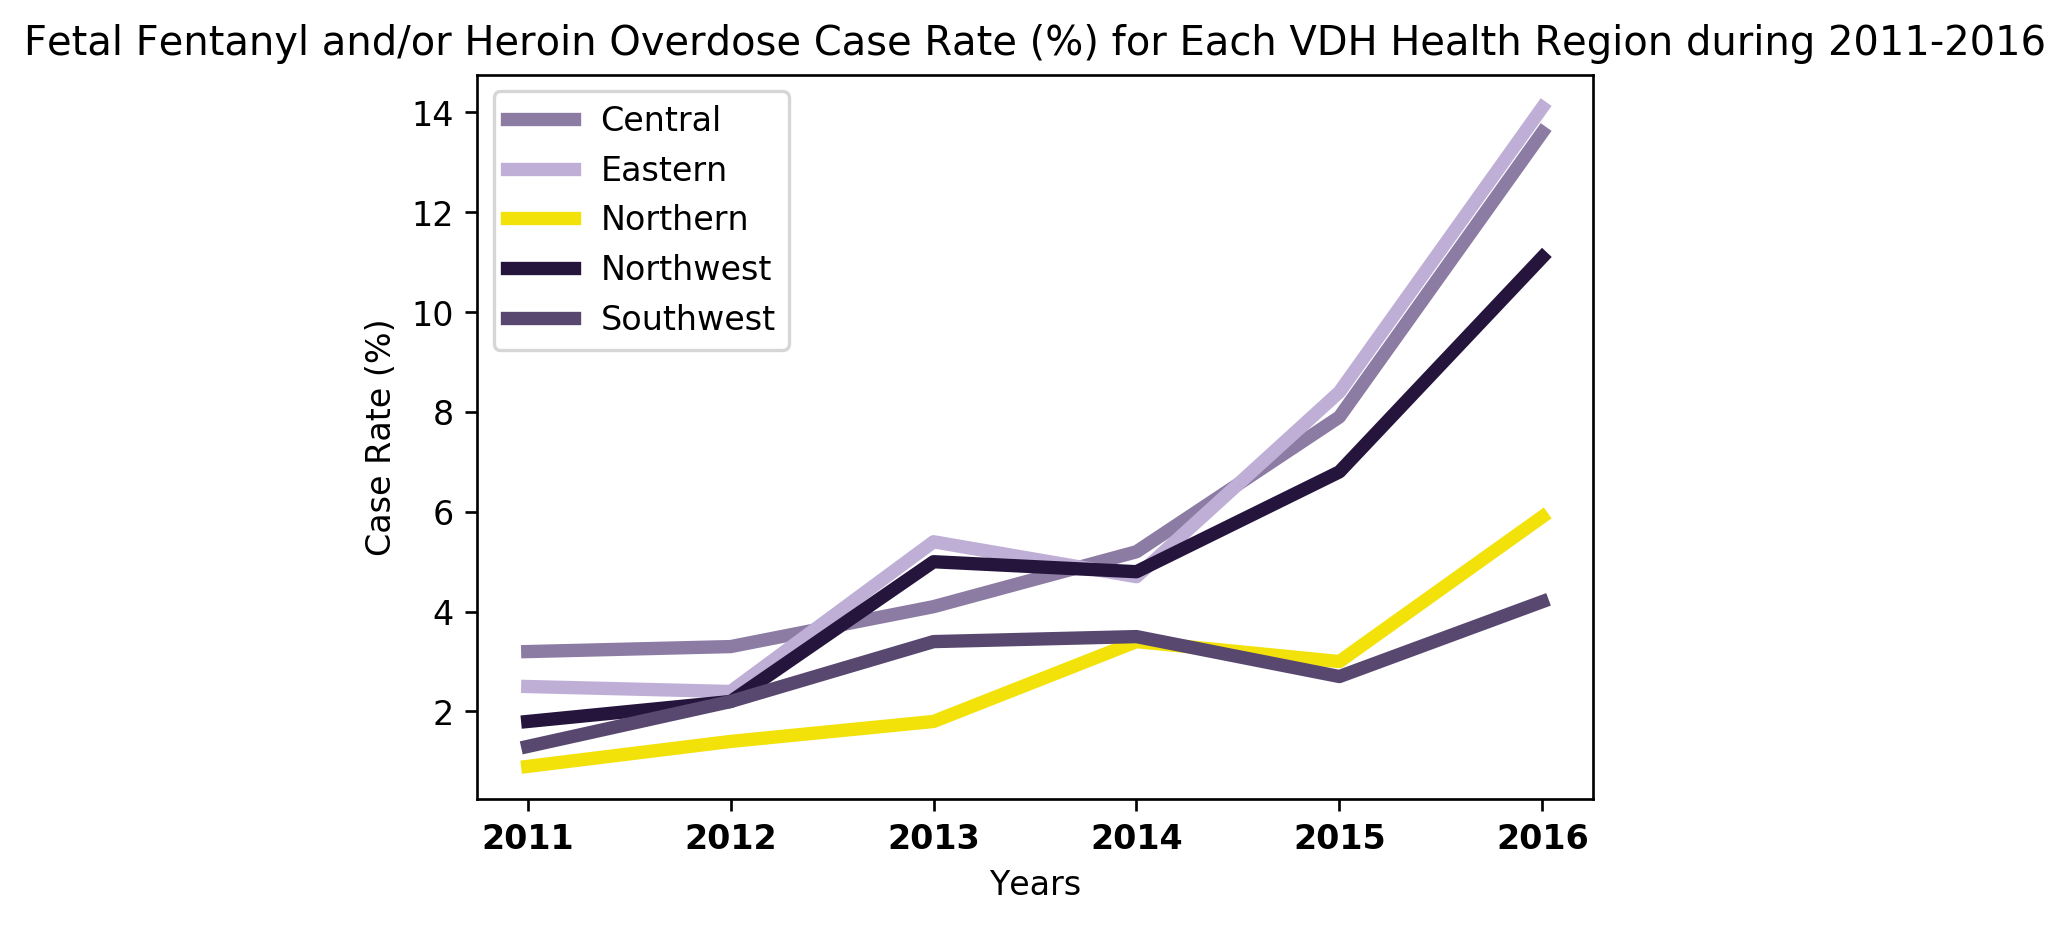

In [19]:
# Case Rate of Fetal Fentanyl and/or Heroin Overdose
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc10
# 1) x -> Year (from 2011 to 2016)
x_names = ["2011", "2012", "2013", "2014", "2015", "2016"]
x_data = [2011, 2012, 2013, 2014, 2015, 2016]
#print("x_data:\n", x_data)
# 2) y -> Rate (col: 12) of Virginia Health Region (col: 10)
    #   a) Name: column 10, Case Count: column 11, Rate: column 12
y_data_names = ['Central', 'Eastern', 'Northern', 'Northwest', 'Southwest']
    #   b) Specify the dataset is df_plt2, Rate (col:12), and Type=='Fatal Fentanyl and/or Heroin Overdose' (col:4)
df_flt0 = (df_plt2[12])[df_plt2[4] == 'Fatal Fentanyl and/or Heroin Overdose']
    #   b) Extract Rate of each VHR each Year into matrix y_data_list[year][region]
y_data_list = []
# Caution! i-->Year; j-->VHR
for i in range (0, 4+1):  # 0~4 is VHR encoded names (col:10)
    df_flt1 = df_flt0[df_plt2[10] == i]
    j_data = []
    for j in range(2011, 2016+1):  # 2011-2016 is Year (col:0)
        df_flt2 = df_flt1[df_plt2[0] == j]
        rate = np.array(df_flt2)[0]
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
#print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
#print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "Years"
y_label = "Case Rate (%)"
title = "Fetal Fentanyl and/or Heroin Overdose Case Rate (%) for Each VDH Health Region during 2011-2016"
# 5) Print plot
multilineplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)

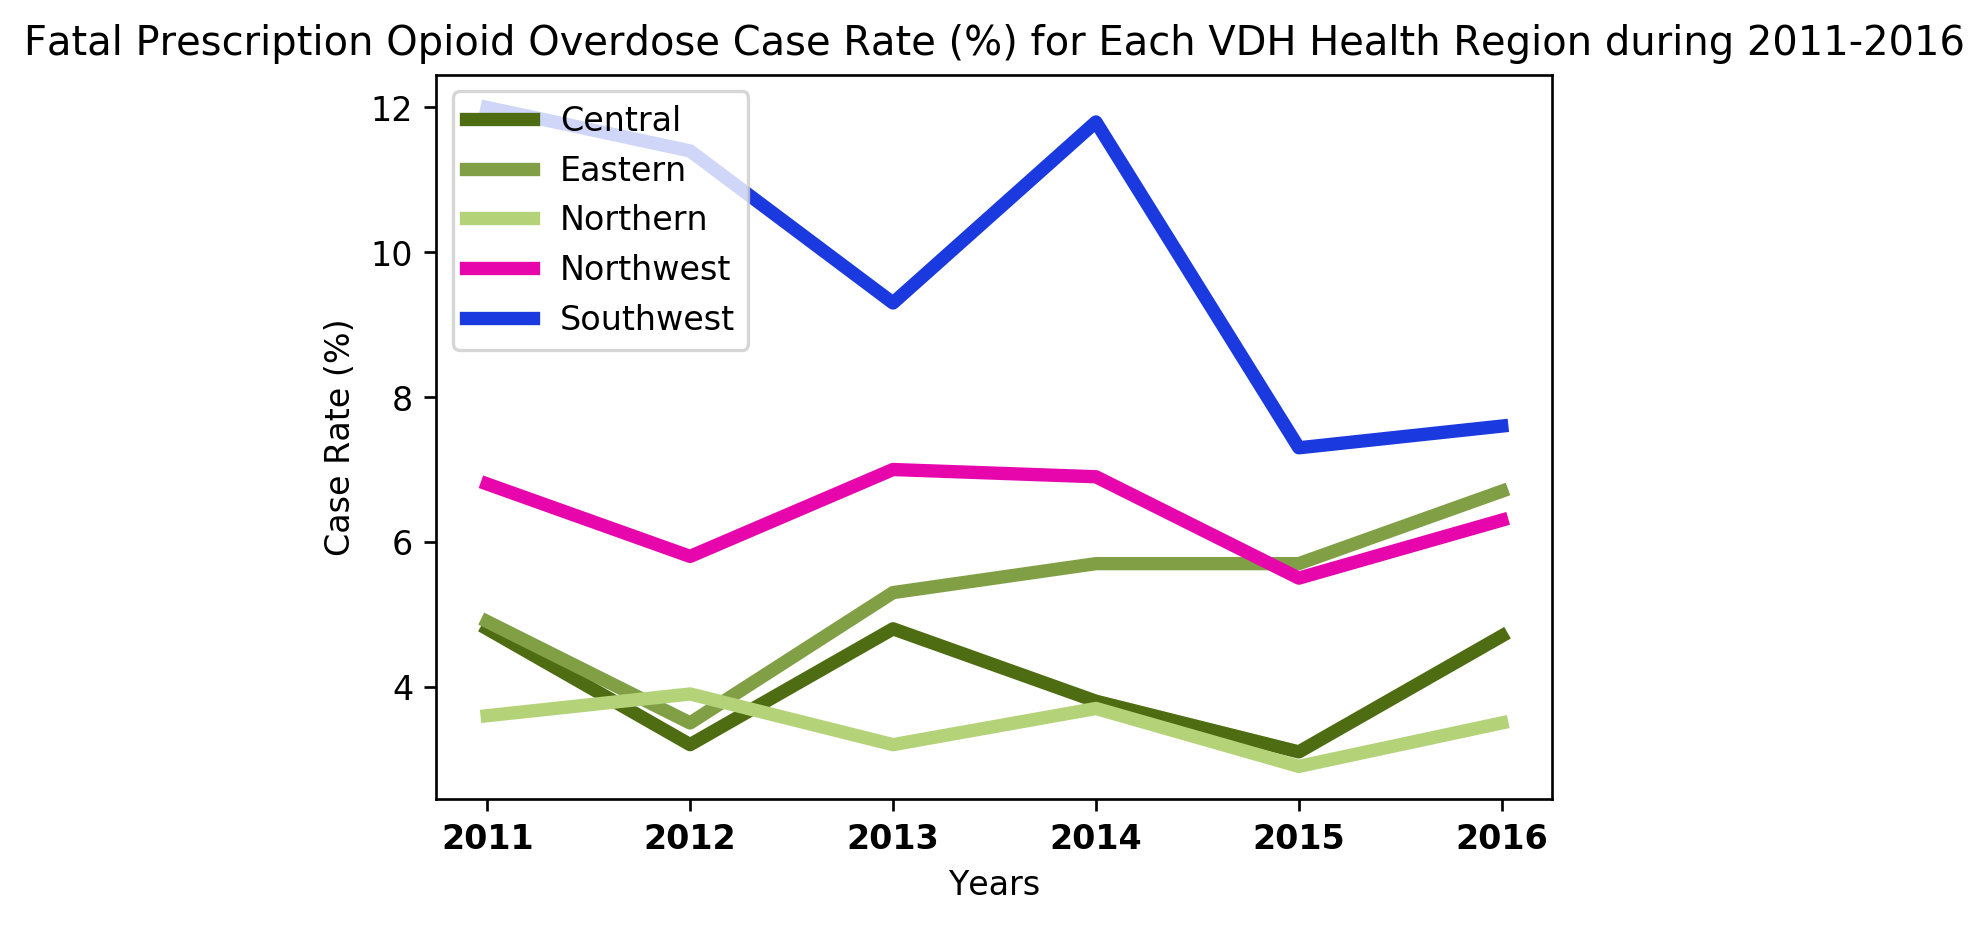

In [20]:
# Case Rate of Fatal Prescription Opioid Overdose
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc10
# 1) x -> Year (from 2011 to 2016)
x_names = ["2011", "2012", "2013", "2014", "2015", "2016"]
x_data = [2011, 2012, 2013, 2014, 2015, 2016]
#print("x_data:\n", x_data)
# 2) y -> Rate (col: 12) of Virginia Health Region (col: 10)
    #   a) Name: column 10, Case Count: column 11, Rate: column 12
y_data_names = ['Central', 'Eastern', 'Northern', 'Northwest', 'Southwest']
    #   b) Specify the dataset is df_plt2, Rate (col:12), and Type=='Fatal Prescription Opioid Overdose' (col:4)
df_flt0 = (df_plt2[12])[df_plt2[4] == 'Fatal Prescription Opioid Overdose']
    #   b) Extract Rate of each VHR each Year into matrix y_data_list[year][region]
y_data_list = []
# Caution! i-->Year; j-->VHR
for i in range (0, 4+1):  # 0~4 is VHR encoded names (col:10)
    df_flt1 = df_flt0[df_plt2[10] == i]
    j_data = []
    for j in range(2011, 2016+1):  # 2011-2016 is Year (col:0)
        df_flt2 = df_flt1[df_plt2[0] == j]
        rate = np.array(df_flt2)[0]
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
#print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
#print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "Years"
y_label = "Case Rate (%)"
title = "Fatal Prescription Opioid Overdose Case Rate (%) for Each VDH Health Region during 2011-2016"
# 5) Print plot
multilineplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)

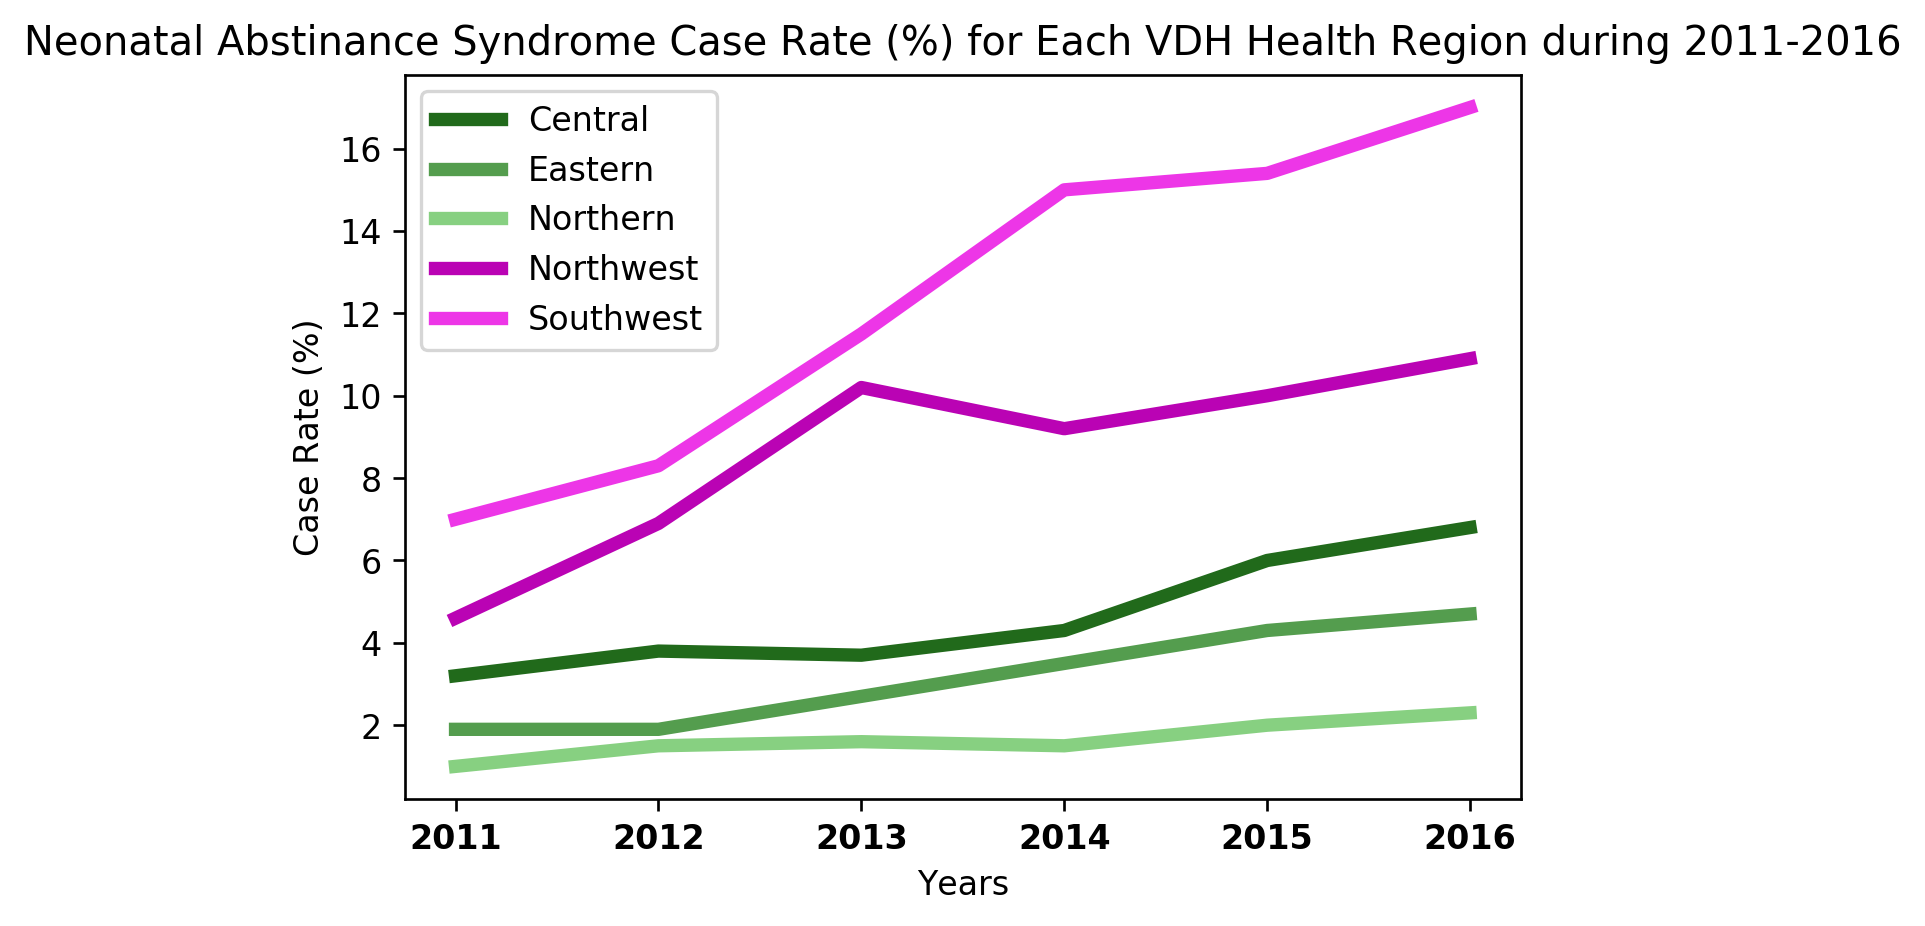

In [21]:
# Case Rate of Neonatal Abstinance Syndrome
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc10
# 1) x -> Year (from 2011 to 2016)
x_names = ["2011", "2012", "2013", "2014", "2015", "2016"]
x_data = [2011, 2012, 2013, 2014, 2015, 2016]
#print("x_data:\n", x_data)
# 2) y -> Rate (col: 12) of Virginia Health Region (col: 10)
    #   a) Name: column 10, Case Count: column 11, Rate: column 12
y_data_names = ['Central', 'Eastern', 'Northern', 'Northwest', 'Southwest']
    #   b) Specify the dataset is df_plt2, Rate (col:12), and Type=='Neonatal Abstinance Syndrome' (col:4)
df_flt0 = (df_plt2[12])[df_plt2[4] == 'Neonatal Abstinance Syndrome']
    #   b) Extract Rate of each VHR each Year into matrix y_data_list[year][region]
y_data_list = []
# Caution! i-->Year; j-->VHR
for i in range (0, 4+1):  # 0~4 is VHR encoded names (col:10)
    df_flt1 = df_flt0[df_plt2[10] == i]
    j_data = []
    for j in range(2011, 2016+1):  # 2011-2016 is Year (col:0)
        df_flt2 = df_flt1[df_plt2[0] == j]
        rate = np.array(df_flt2)[0]
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
#print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
#print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "Years"
y_label = "Case Rate (%)"
title = "Neonatal Abstinance Syndrome Case Rate (%) for Each VDH Health Region during 2011-2016"
# 5) Print plot
multilineplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)

x_data:
 [0, 1, 2, 3, 4, 5, 6]
y_data_list:
 [[14.2, 18.6, 8.2, 22.6, 7.7, 16.8, 3.3], [27.9, 29.7, 15.8, 25.6, 15.1, 20.5, 6.9], [25.1, 21.8, 21.9, 23.2, 10.7, 13.8, 10.4], [47.7, 35.8, 21.2, 27.3, 24.7, 29.1, 11.2], [51.0, 45.7, 36.8, 36.7, 38.1, 33.9, 15.6], [77.5, 66.3, 35.7, 34.4, 58.8, 40.2, 25.9]]
the generated random colors:
 ['#e34938', '#0d7362', '#379d8c', '#61c7b6', '#8bf1e0', '#b51b0a']


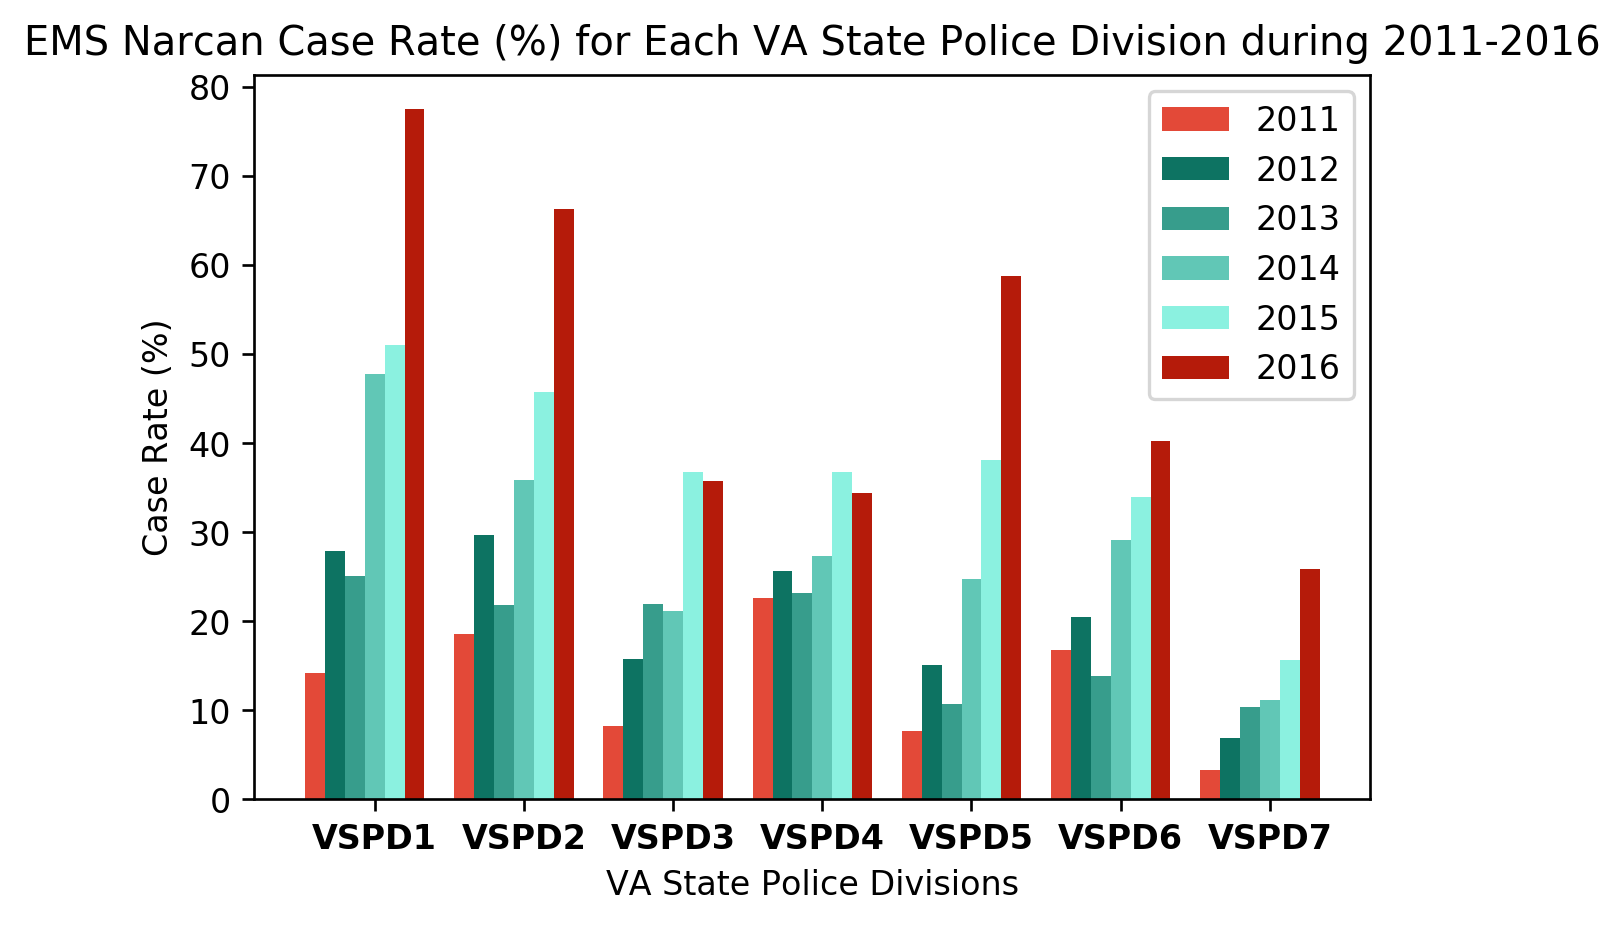

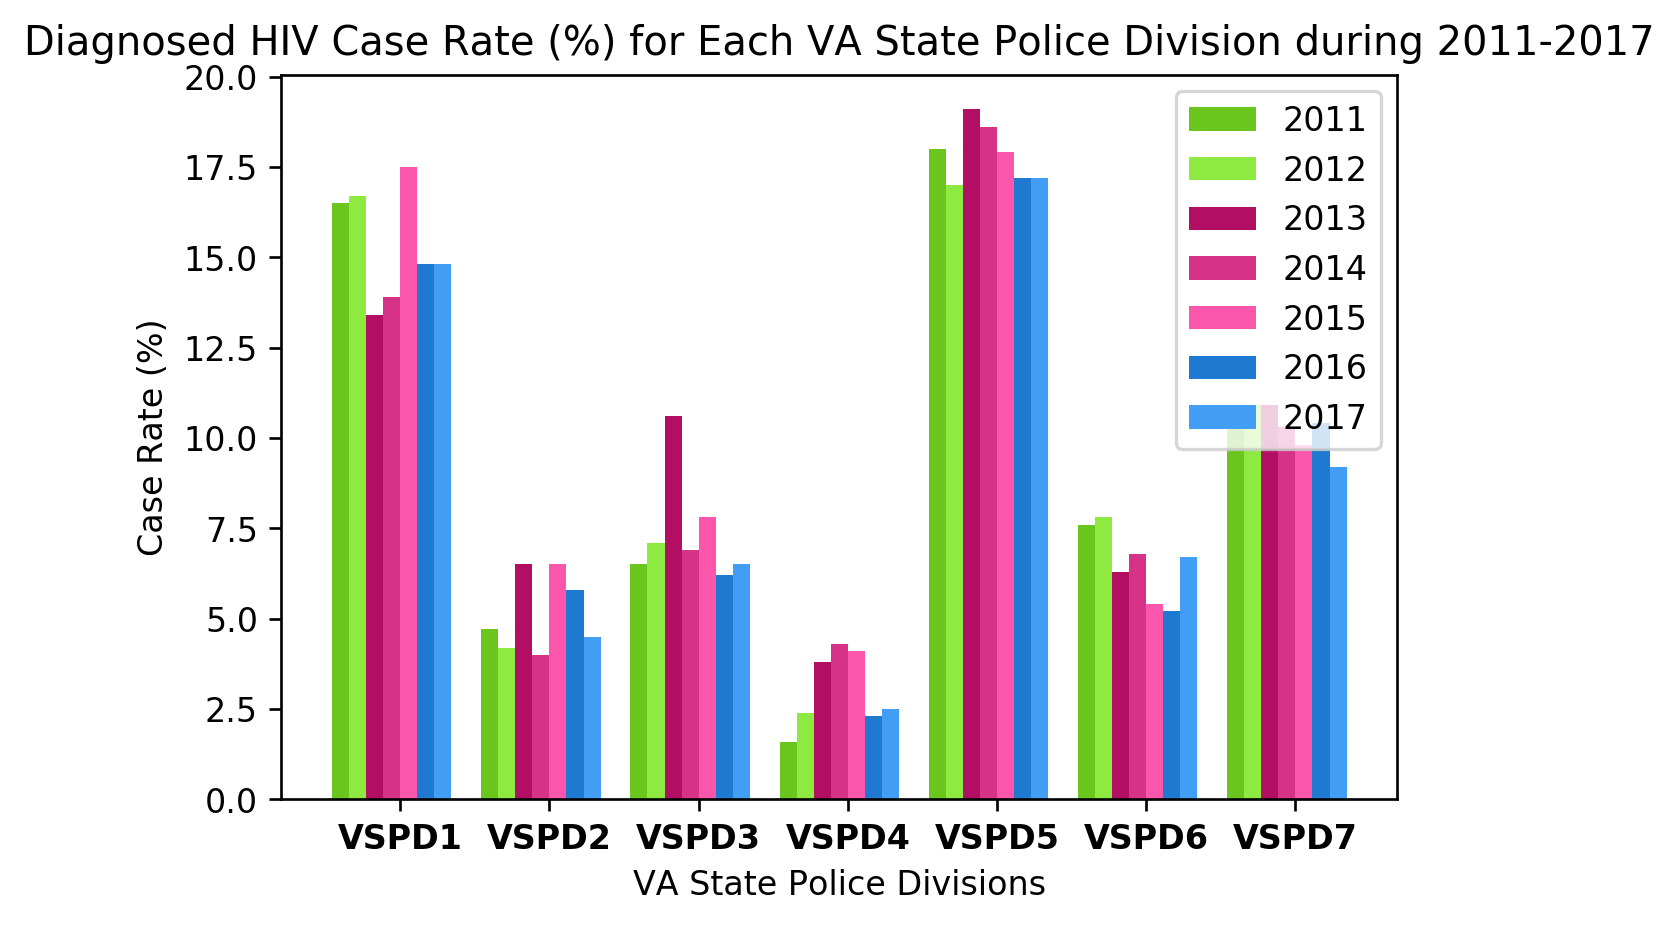

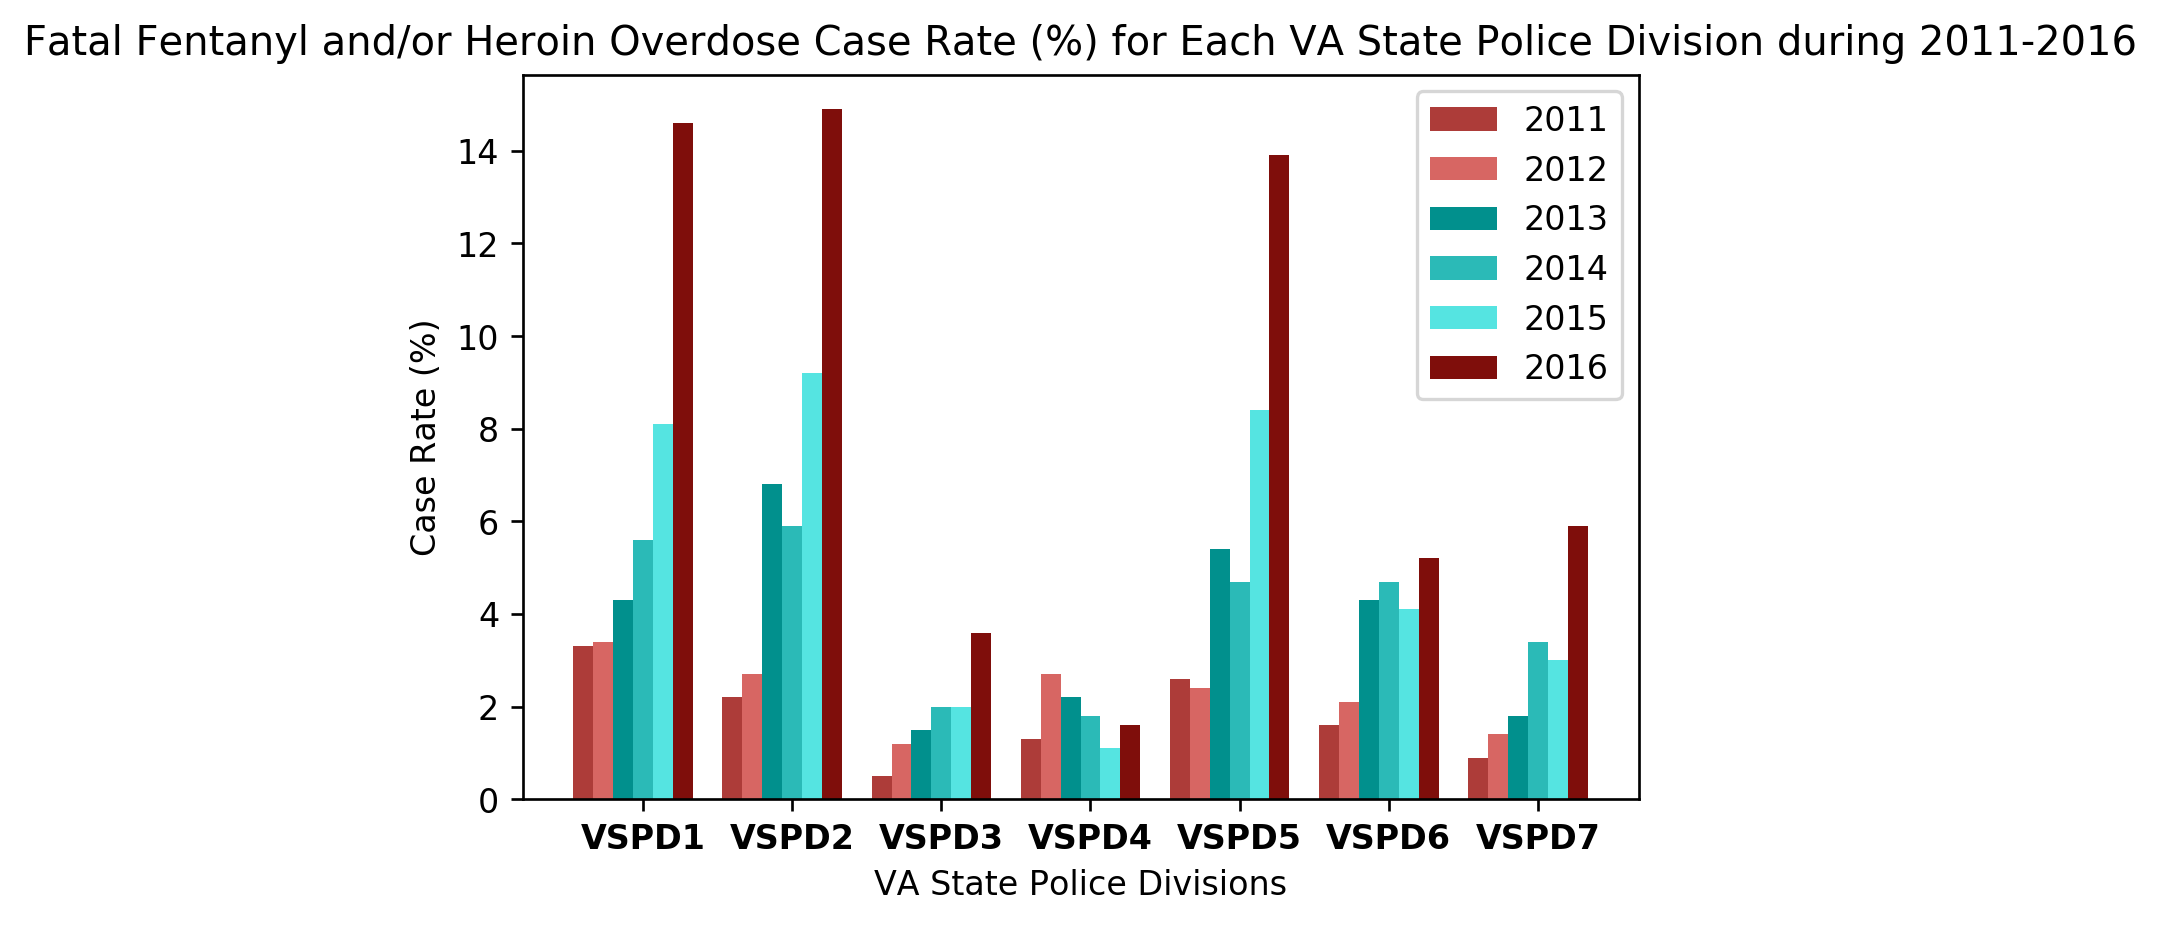

In [22]:
# part2: Case Rates by VSPD (group_bar_plot)
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc

# In this part, we plot a graph that shows the case count rate of
# "EMS Narcan" in each police division from 2011 to 2016.
# For this purpose, we need the following data:
# 1) x -> VA State Police Division 1~7
    #   a) Name: column 22, Case Count: column 23, Rate: column 24
x_names = ['VSPD1', 'VSPD2', 'VSPD3', 'VSPD4', 'VSPD5', 'VSPD6', 'VSPD7',]
x_data = sorted(df_plt2[22].unique())
print("x_data:\n", x_data)
# 2) y -> Rate (col: 24) of each Year (col: 0)
y_data_names = ["2011", "2012", "2013", "2014", "2015", "2016"]
    #   a) Specify the dataset is df_plt2, Rate (col:24), and Type=='EMS Narcan' (col:4)
df_flt0 = (df_plt2[24])[df_plt2[4] == 'EMS Narcan']
    #   b) Extract Rate of each PD each Year into matrix y_data_list[division][year]
y_data_list = []
# Caution! i-->Year; j-->VSPD
for i in range (2011, 2016+1):  # 2011-2016 is Year (col:0)
    df_flt1 = df_flt0[df_plt2[0] == i]
    j_data = []
    for j in range(0, 6+1):  # 0~6 is VSPD1~VSPD7 (col:22)
        df_flt2 = df_flt1[df_plt2[22] == j]
        rate = np.array(df_flt2)[0]
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "VA State Police Divisions"
y_label = "Case Rate (%)"
title = "EMS Narcan Case Rate (%) for Each VA State Police Division during 2011-2016"
# 5) Print plot
groupedbarplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)


# Case Rate of Diagnosed HIV
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc
# 1) x -> VA State Police Division 1~7
    #   a) Name: column 22, Case Count: column 23, Rate: column 24
x_names = ['VSPD1', 'VSPD2', 'VSPD3', 'VSPD4', 'VSPD5', 'VSPD6', 'VSPD7',]
x_data = sorted(df_plt2[22].unique())
#print("x_data:\n", x_data)
# 2) y -> Rate (col: 24) of each Year (col: 0)
y_data_names = ["2011", "2012", "2013", "2014", "2015", "2016", "2017"]
    #   a) Specify the dataset is df_plt2, Rate (col:24), and Type=='Diagnosed HIV' (col:4)
df_flt0 = (df_plt2[24])[df_plt2[4] == 'Diagnosed HIV']
    #   b) Extract Rate of each PD each Year into matrix y_data_list[division][year]
y_data_list = []
# Caution! i-->Year; j-->VSPD
for i in range (2011, 2017+1):  # 2011-2016 is Year (col:0)
    df_flt1 = df_flt0[df_plt2[0] == i]
    j_data = []
    for j in range(0, 6+1):  # 0~6 is VSPD1~VSPD7 (col:22)
        df_flt2 = df_flt1[df_plt2[22] == j]
        rate = np.array(df_flt2)[0]
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
#print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
#print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "VA State Police Divisions"
y_label = "Case Rate (%)"
title = "Diagnosed HIV Case Rate (%) for Each VA State Police Division during 2011-2017"
# 5) Print plot
groupedbarplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)

# Case Rate of Fatal Fentanyl and/or Heroin Overdose
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc
# 1) x -> VA State Police Division 1~7
    #   a) Name: column 22, Case Count: column 23, Rate: column 24
x_names = ['VSPD1', 'VSPD2', 'VSPD3', 'VSPD4', 'VSPD5', 'VSPD6', 'VSPD7',]
x_data = sorted(df_plt2[22].unique())
#print("x_data:\n", x_data)
# 2) y -> Rate (col: 24) of each Year (col: 0)
y_data_names = ["2011", "2012", "2013", "2014", "2015", "2016"]
    #   a) Specify the dataset is df_plt2, Rate (col:24), and Type=='Fetal Fentanyl and/or Heroin Overdose' (col:4)
df_flt0 = (df_plt2[24])[df_plt2[4] == 'Fatal Fentanyl and/or Heroin Overdose']
    #   b) Extract Rate of each PD each Year into matrix y_data_list[division][year]
y_data_list = []
# Caution! i-->Year; j-->VSPD
for i in range (2011, 2016+1):  # 2011-2016 is Year (col:0)
    df_flt1 = df_flt0[df_plt2[0] == i]
    j_data = []
    for j in range(0, 6+1):  # 0~6 is VSPD1~VSPD7 (col:22)
        df_flt2 = df_flt1[df_plt2[22] == j]
        rate = np.array(df_flt2)[0]
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
#print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
#print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "VA State Police Divisions"
y_label = "Case Rate (%)"
title = "Fatal Fentanyl and/or Heroin Overdose Case Rate (%) for Each VA State Police Division during 2011-2016"
# 5) Print plot
groupedbarplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)

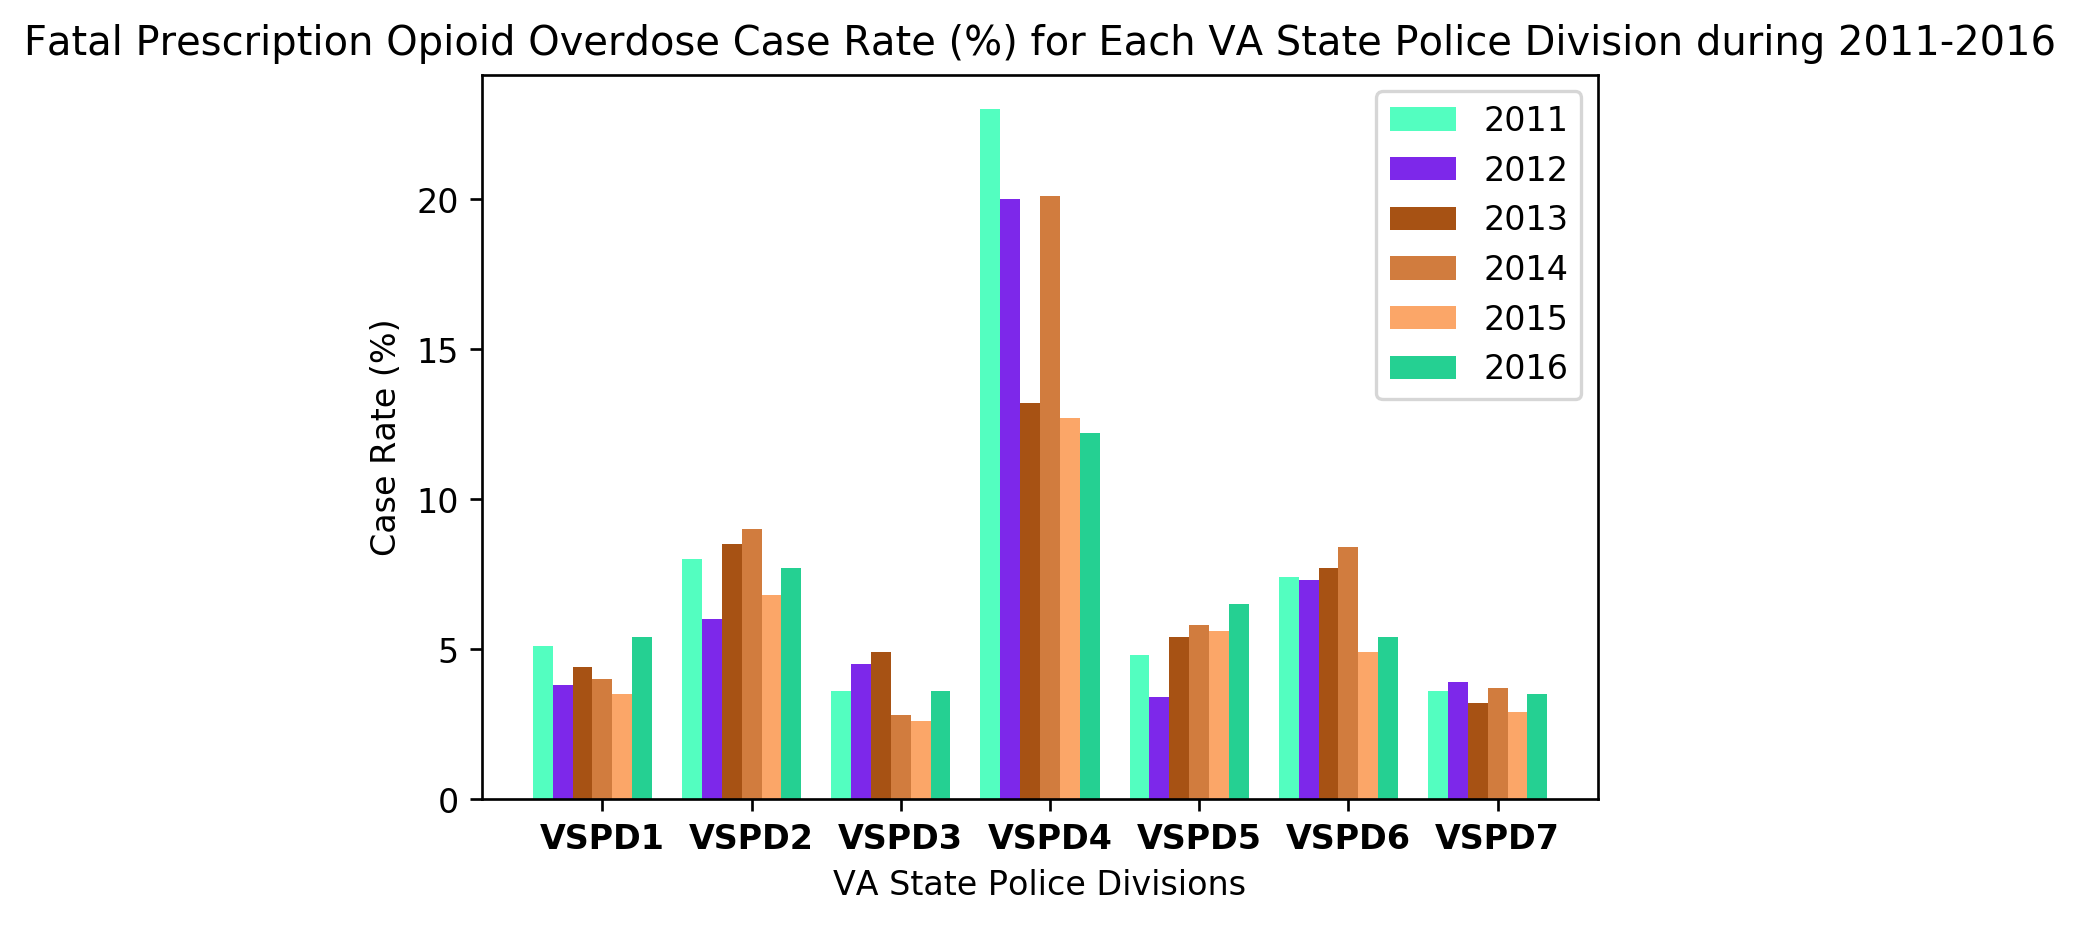

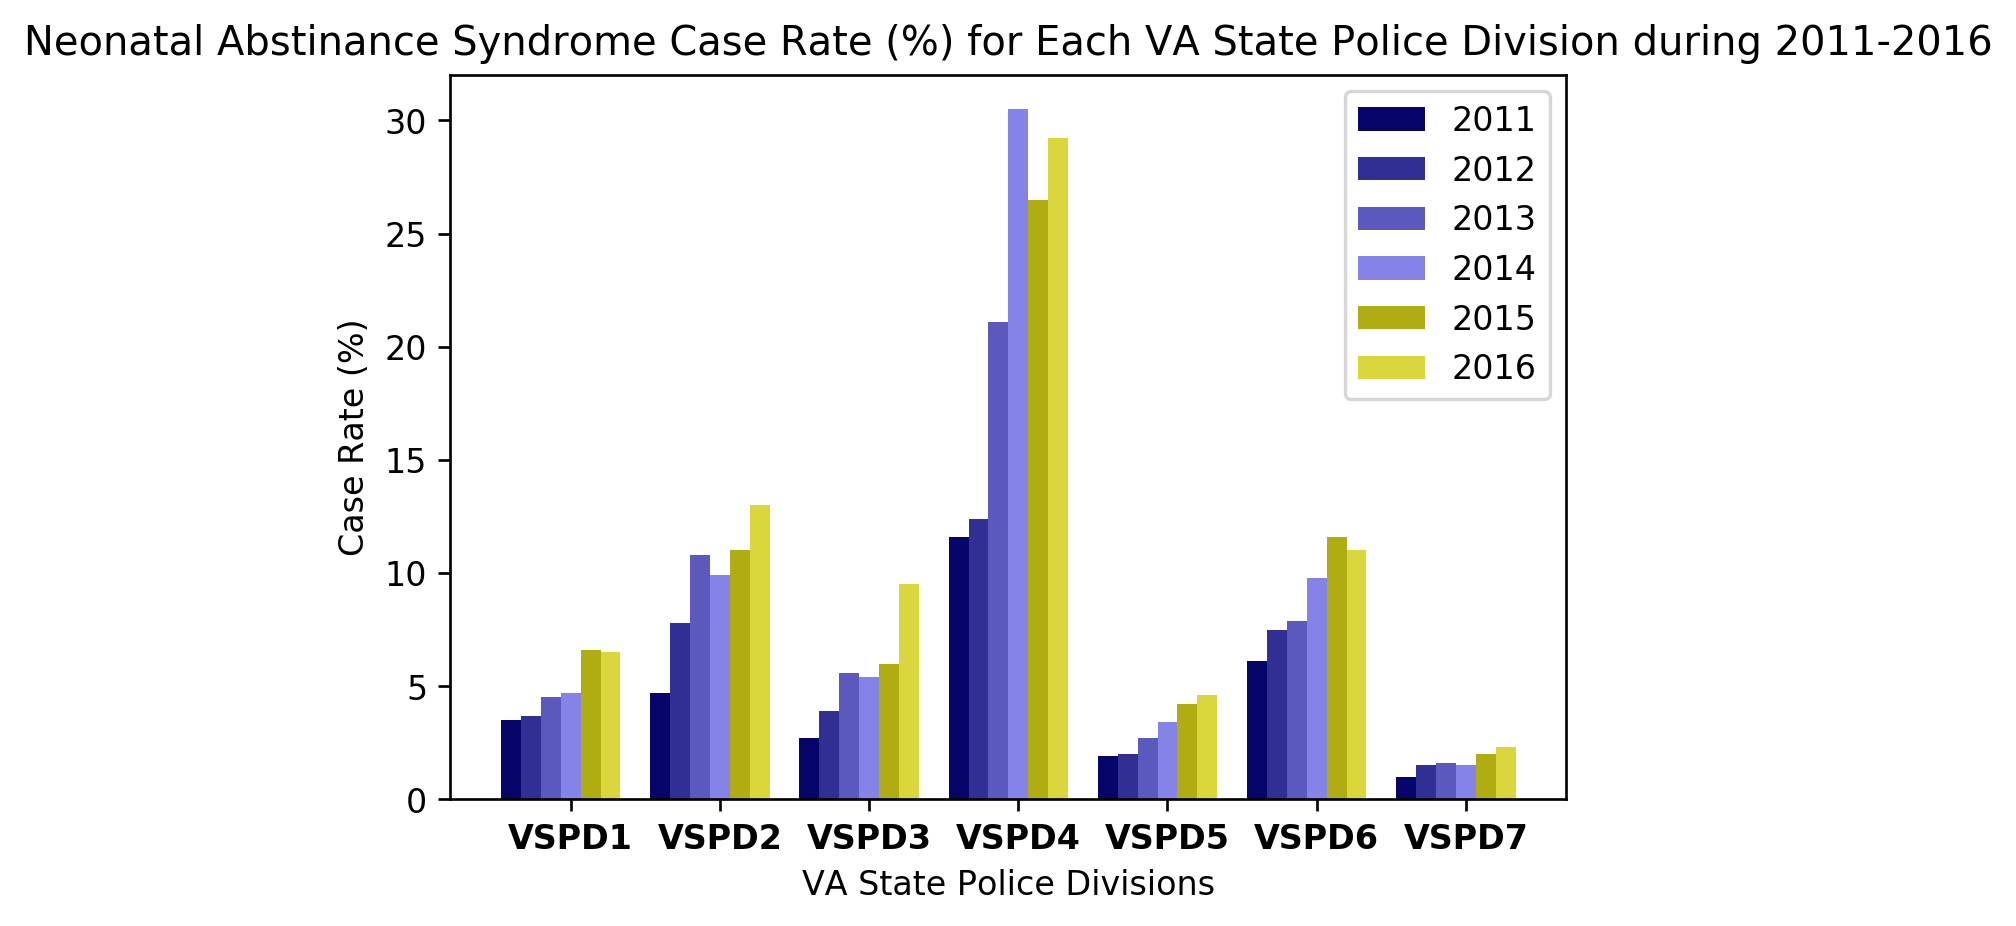

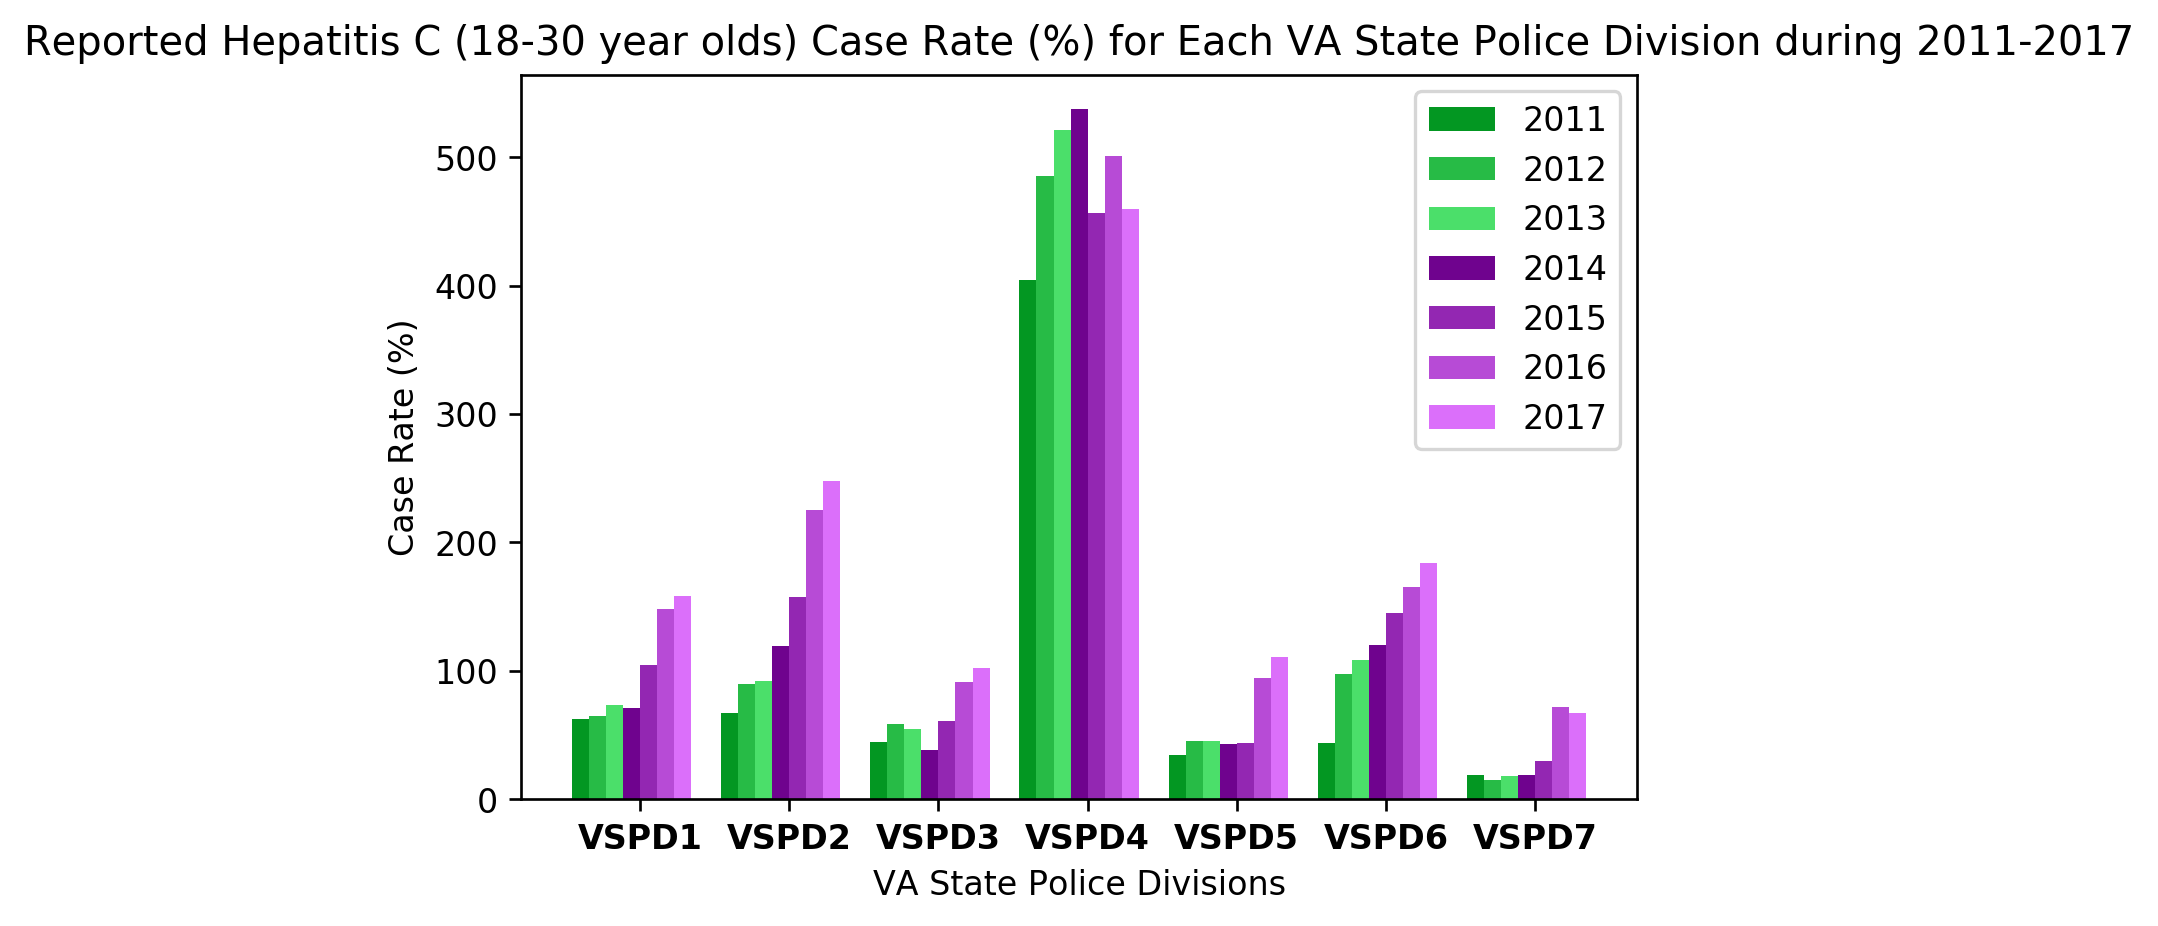

In [23]:
# Case Rate of Fatal Prescription Opioid Overdose
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc
# 1) x -> VA State Police Division 1~7
    #   a) Name: column 22, Case Count: column 23, Rate: column 24
x_names = ['VSPD1', 'VSPD2', 'VSPD3', 'VSPD4', 'VSPD5', 'VSPD6', 'VSPD7',]
x_data = sorted(df_plt2[22].unique())
#print("x_data:\n", x_data)
# 2) y -> Rate (col: 24) of each Year (col: 0)
y_data_names = ["2011", "2012", "2013", "2014", "2015", "2016"]
    #   a) Specify the dataset is df_plt2, Rate (col:24), and Type=='Fatal Prescription Opioid Overdose' (col:4)
df_flt0 = (df_plt2[24])[df_plt2[4] == 'Fatal Prescription Opioid Overdose']
    #   b) Extract Rate of each PD each Year into matrix y_data_list[division][year]
y_data_list = []
# Caution! i-->Year; j-->VSPD
for i in range (2011, 2016+1):  # 2011-2016 is Year (col:0)
    df_flt1 = df_flt0[df_plt2[0] == i]
    j_data = []
    for j in range(0, 6+1):  # 0~6 is VSPD1~VSPD7 (col:22)
        df_flt2 = df_flt1[df_plt2[22] == j]
        rate = np.array(df_flt2)[0]
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
#print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
#print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "VA State Police Divisions"
y_label = "Case Rate (%)"
title = "Fatal Prescription Opioid Overdose Case Rate (%) for Each VA State Police Division during 2011-2016"
# 5) Print plot
groupedbarplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)


# Case Rate of Neonatal Abstinance Syndrome
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc
# 1) x -> VA State Police Division 1~7
    #   a) Name: column 22, Case Count: column 23, Rate: column 24
x_names = ['VSPD1', 'VSPD2', 'VSPD3', 'VSPD4', 'VSPD5', 'VSPD6', 'VSPD7',]
x_data = sorted(df_plt2[22].unique())
#print("x_data:\n", x_data)
# 2) y -> Rate (col: 24) of each Year (col: 0)
y_data_names = ["2011", "2012", "2013", "2014", "2015", "2016"]
    #   a) Specify the dataset is df_plt2, Rate (col:24), and Type=='Neonatal Abstinance Syndrome' (col:4)
df_flt0 = (df_plt2[24])[df_plt2[4] == 'Neonatal Abstinance Syndrome']
    #   b) Extract Rate of each PD each Year into matrix y_data_list[division][year]
y_data_list = []
# Caution! i-->Year; j-->VSPD
for i in range (2011, 2016+1):  # 2011-2016 is Year (col:0)
    df_flt1 = df_flt0[df_plt2[0] == i]
    j_data = []
    for j in range(0, 6+1):  # 0~6 is VSPD1~VSPD7 (col:22)
        df_flt2 = df_flt1[df_plt2[22] == j]
        rate = np.array(df_flt2)[0]
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
#print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
#print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "VA State Police Divisions"
y_label = "Case Rate (%)"
title = "Neonatal Abstinance Syndrome Case Rate (%) for Each VA State Police Division during 2011-2016"
# 5) Print plot
groupedbarplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)


# Case Rate of Reported Hepatitis C (18-30 year olds)
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc
# 1) x -> VA State Police Division 1~7
    #   a) Name: column 22, Case Count: column 23, Rate: column 24
x_names = ['VSPD1', 'VSPD2', 'VSPD3', 'VSPD4', 'VSPD5', 'VSPD6', 'VSPD7',]
x_data = sorted(df_plt2[22].unique())
#print("x_data:\n", x_data)
# 2) y -> Rate (col: 24) of each Year (col: 0)
y_data_names = ["2011", "2012", "2013", "2014", "2015", "2016", "2017"]
    #   a) Specify the dataset is df_plt2, Rate (col:24), and Type=='Reported Hepatitis C (18-30 year olds)' (col:4)
df_flt0 = (df_plt2[24])[df_plt2[4] == 'Reported Hepatitis C (18-30 year olds)']
    #   b) Extract Rate of each PD each Year into matrix y_data_list[division][year]
y_data_list = []
# Caution! i-->Year; j-->VSPD
for i in range (2011, 2017+1):  # 2011-2017 is Year (col:0)
    df_flt1 = df_flt0[df_plt2[0] == i]
    j_data = []
    for j in range(0, 6+1):  # 0~6 is VSPD1~VSPD7 (col:22)
        df_flt2 = df_flt1[df_plt2[22] == j]
        rate = np.array(df_flt2)[0]
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
#print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
#print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "VA State Police Divisions"
y_label = "Case Rate (%)"
title = "Reported Hepatitis C (18-30 year olds) Case Rate (%) for Each VA State Police Division during 2011-2017"
# 5) Print plot
groupedbarplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)

x_data:
 ['Central', 'Eastern', 'Northern', 'Northwest', 'Southwest']
y_data_list:
 [[227, 317, 244, 67, 78], [231, 307, 255, 64, 83], [201, 340, 261, 87, 88], [203, 329, 250, 63, 86], [254, 325, 239, 91, 68], [219, 317, 256, 64, 63], [220, 307, 227, 65, 75]]
the generated random colors:
 ['#319037', '#55b45b', '#79d87f', '#9dfca3', '#c120c7', '#e544eb', '#09680f']


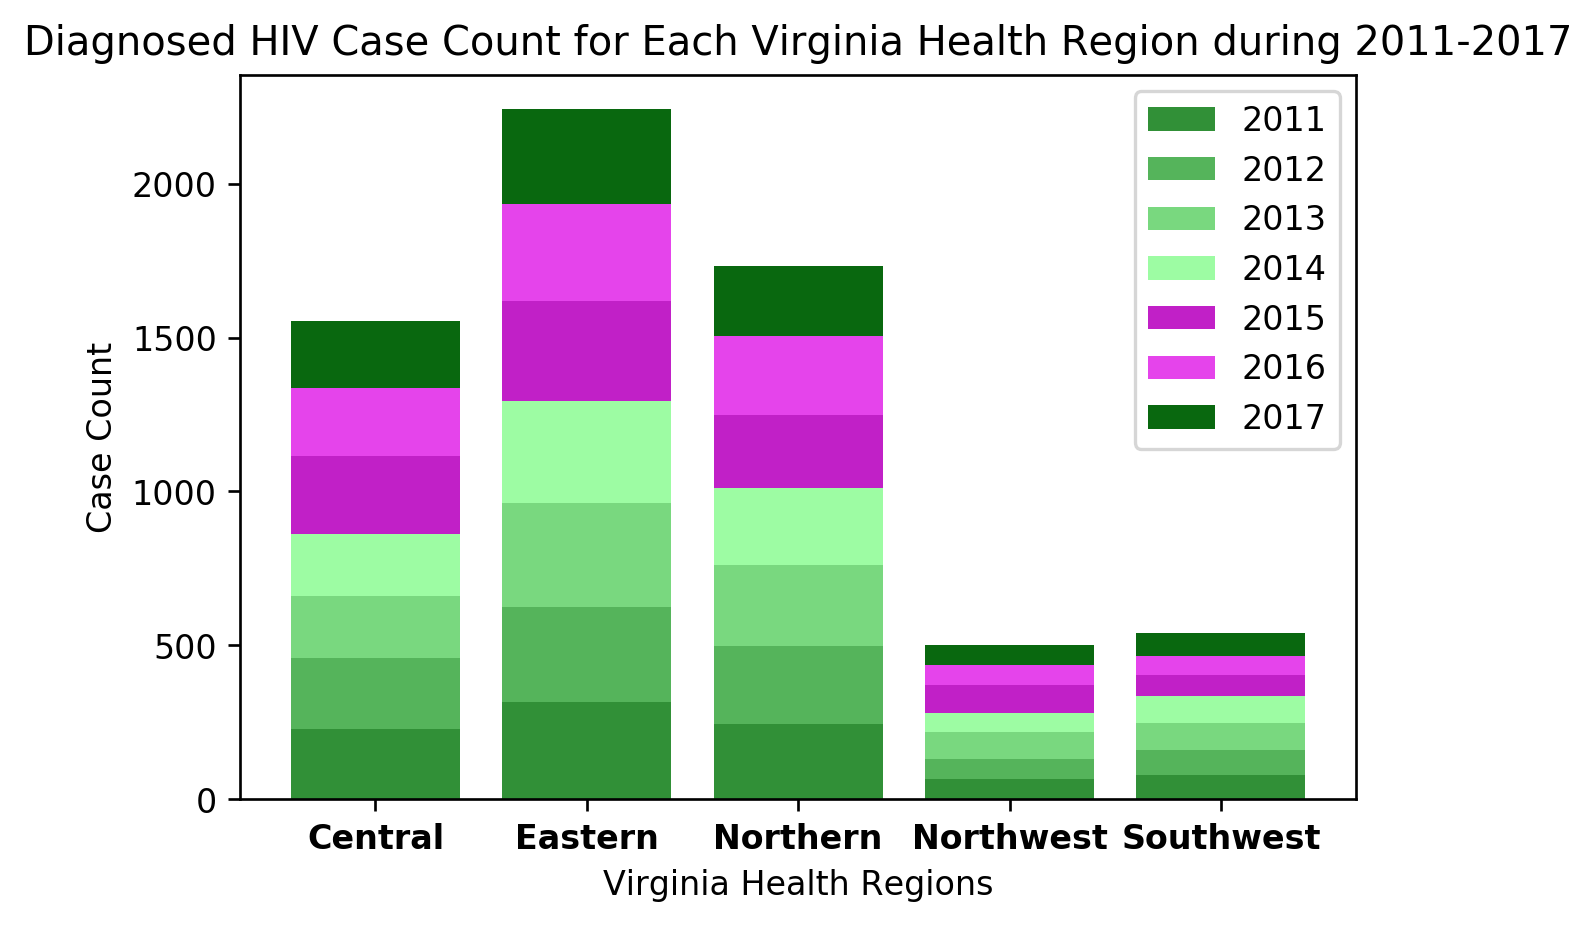

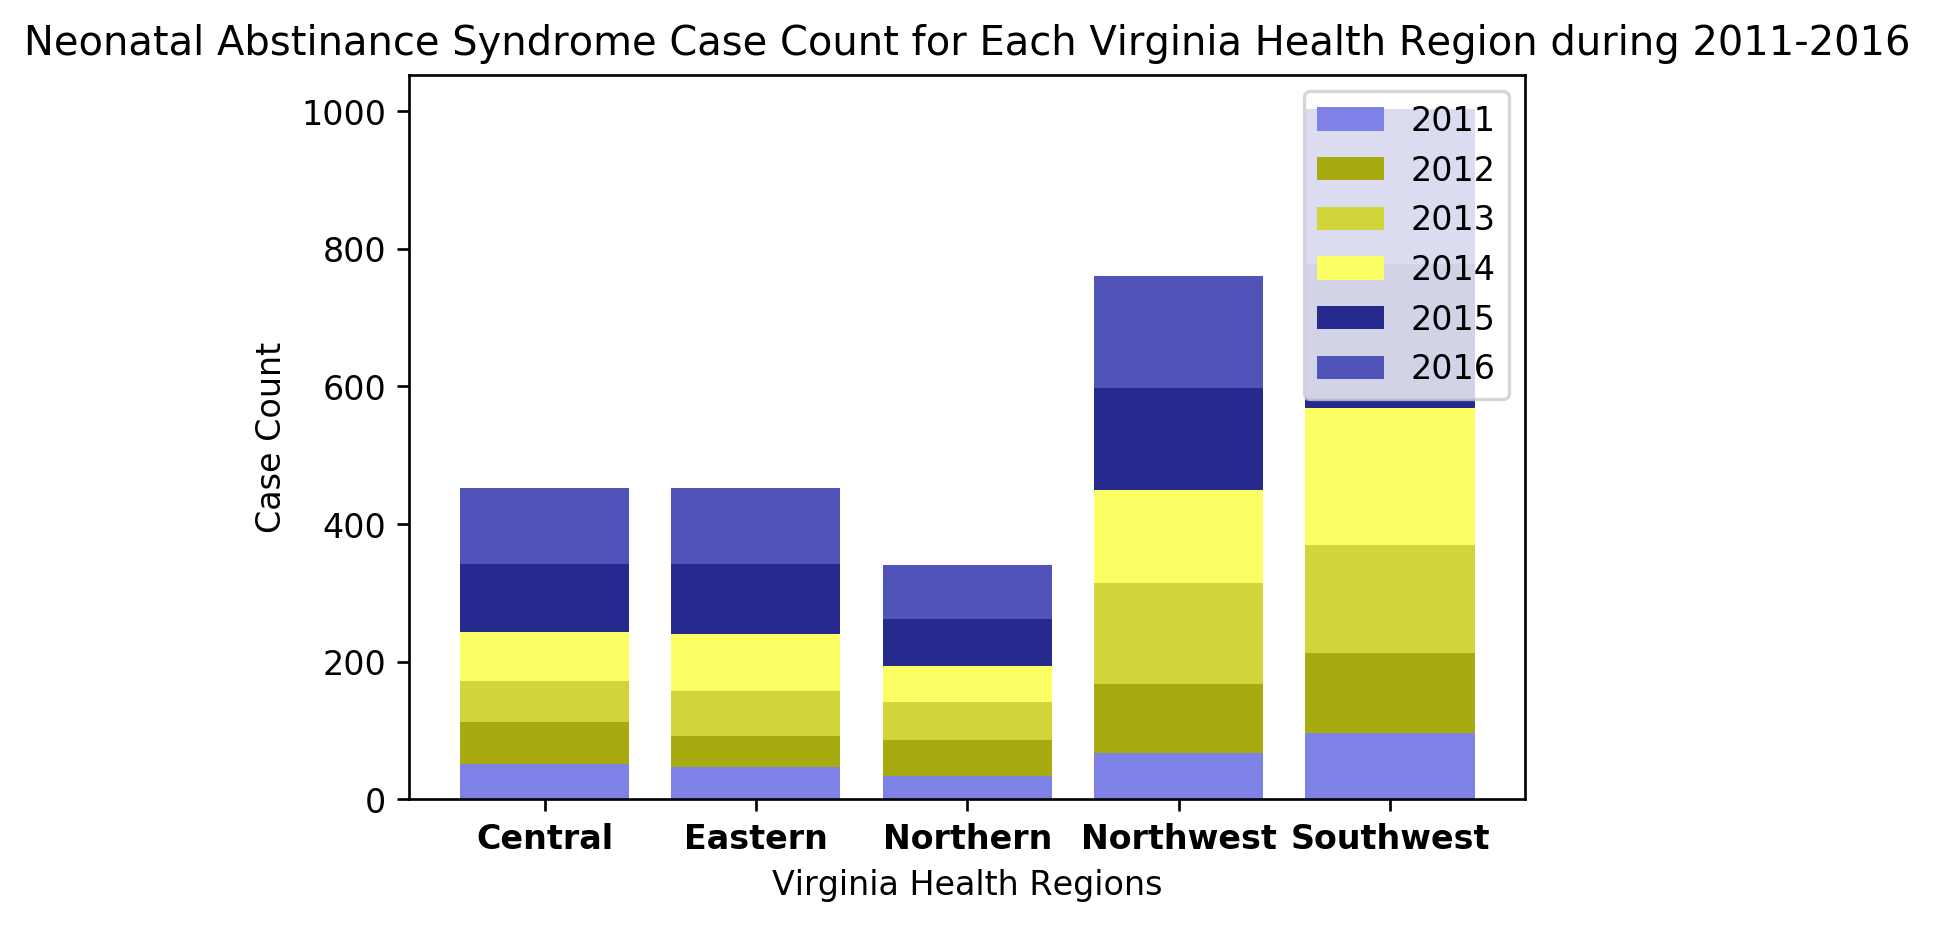

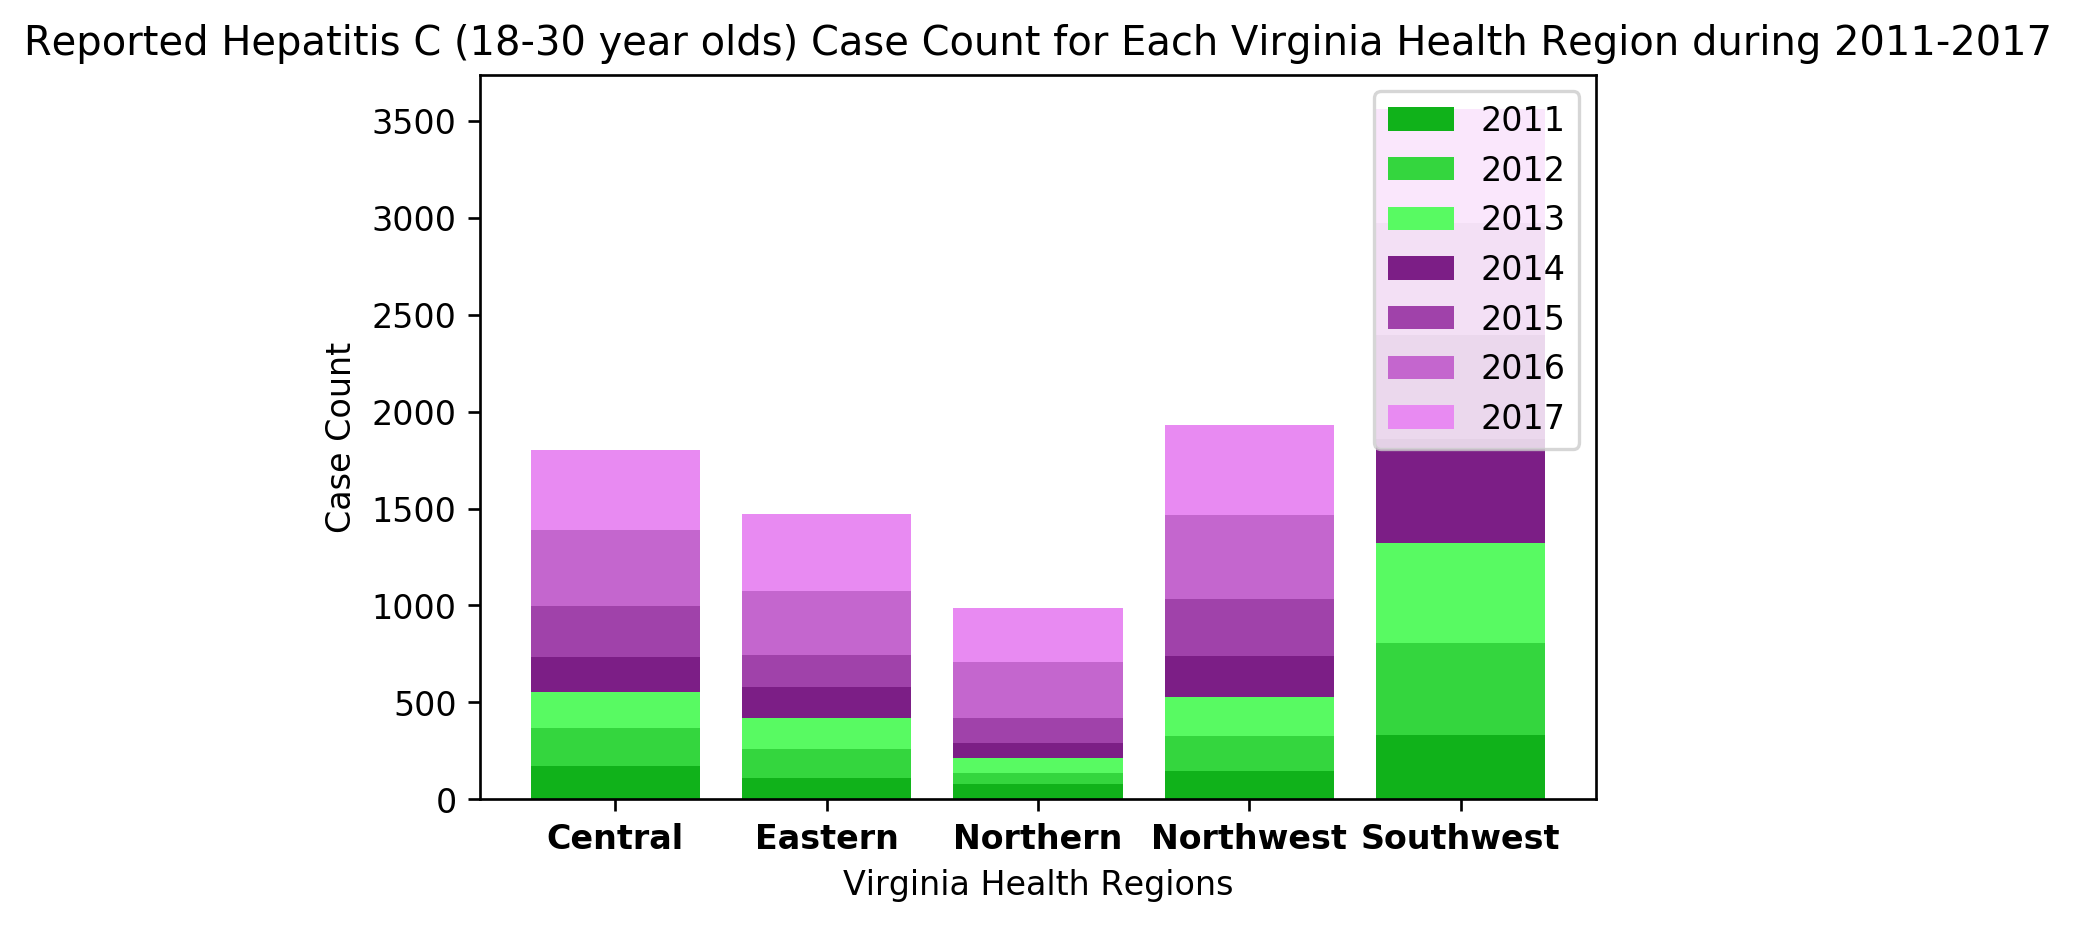

In [24]:
# part3: Case Count by VHR (stacked_bar_plot)
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc

# In this part, we plot a graph that shows the case count of
# "Diagnosed HIV" in each police division from 2011 to 2017.
# For this purpose, we need the following data:
# 1) x -> -> Rate (col: 12) of Virginia Health Region (col: 10)
    #   a) Name: column 10, Case Count: column 11, Rate: column 12
x_names = ['Central', 'Eastern', 'Northern', 'Northwest', 'Southwest']
x_data = sorted(df_plt2[10].unique())
print("x_data:\n", x_data)
# 2) y -> Case Count (col: 11) of each Year (col: 0)
y_data_names = ["2011", "2012", "2013", "2014", "2015", "2016", "2017"]
    #   a) Specify the dataset is df_plt2, Count (col:11), and Type=='Diagnosed HIV' (col:4)
df_flt0 = (df_plt2[11])[df_plt2[4] == 'Diagnosed HIV']
    #   b) Extract Rate of each PD each Year into matrix y_data_list[division][year]
y_data_list = []
# Caution! i-->Year; j-->VSPD
for i in range (2011, 2017+1):  # 2011-2017 is Year (col:0)
    df_flt1 = df_flt0[df_plt2[0] == i]
    j_data = []
    for j in range(0, len(x_data)):  # 0~6 is VSPD1~VSPD7 (col:22)
        df_flt2 = df_flt1[df_plt2[10] == x_data[j]]
        rate = int(np.array(df_flt2)[0])
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "Virginia Health Regions"
y_label = "Case Count"
title = "Diagnosed HIV Case Count for Each Virginia Health Region during 2011-2017"
# 5) Print plot
stackedbarplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)


# Case Rate of Neonatal Abstinance Syndrome
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc
# 1) x -> -> Rate (col: 12) of Virginia Health Region (col: 10)
    #   a) Name: column 10, Case Count: column 11, Rate: column 12
x_names = ['Central', 'Eastern', 'Northern', 'Northwest', 'Southwest']
x_data = sorted(df_plt2[10].unique())
#print("x_data:\n", x_data)
# 2) y -> Case Count (col: 11) of each Year (col: 0)
y_data_names = ["2011", "2012", "2013", "2014", "2015", "2016"]
    #   a) Specify the dataset is df_plt2, Count (col:11), and Type=='Neonatal Abstinance Syndrome' (col:4)
df_flt0 = (df_plt2[11])[df_plt2[4] == 'Neonatal Abstinance Syndrome']
    #   b) Extract Rate of each PD each Year into matrix y_data_list[division][year]
y_data_list = []
# Caution! i-->Year; j-->VSPD
for i in range (2011, 2016+1):  # 2011-2017 is Year (col:0)
    df_flt1 = df_flt0[df_plt2[0] == i]
    j_data = []
    for j in range(0, len(x_data)):  # 0~6 is VSPD1~VSPD7 (col:22)
        df_flt2 = df_flt1[df_plt2[10] == x_data[j]]
        rate = int(np.array(df_flt2)[0])
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
#print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
#print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "Virginia Health Regions"
y_label = "Case Count"
title = "Neonatal Abstinance Syndrome Case Count for Each Virginia Health Region during 2011-2016"
# 5) Print plot
stackedbarplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)


# Case Rate of Reported Hepatitis C (18-30 year olds)
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc
# 1) x -> -> Rate (col: 12) of Virginia Health Region (col: 10)
    #   a) Name: column 10, Case Count: column 11, Rate: column 12
x_names = ['Central', 'Eastern', 'Northern', 'Northwest', 'Southwest']
x_data = sorted(df_plt2[10].unique())
#print("x_data:\n", x_data)
# 2) y -> Case Count (col: 11) of each Year (col: 0)
y_data_names = ["2011", "2012", "2013", "2014", "2015", "2016", "2017"]
    #   a) Specify the dataset is df_plt2, Count (col:11), and Type=='Reported Hepatitis C (18-30 year olds)' (col:4)
df_flt0 = (df_plt2[11])[df_plt2[4] == 'Reported Hepatitis C (18-30 year olds)']
    #   b) Extract Rate of each PD each Year into matrix y_data_list[division][year]
y_data_list = []
# Caution! i-->Year; j-->VSPD
for i in range (2011, 2017+1):  # 2011-2017 is Year (col:0)
    df_flt1 = df_flt0[df_plt2[0] == i]
    j_data = []
    for j in range(0, len(x_data)):  # 0~6 is VSPD1~VSPD7 (col:22)
        df_flt2 = df_flt1[df_plt2[10] == x_data[j]]
        rate = int(np.array(df_flt2)[0])
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
#print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
#print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "Virginia Health Regions"
y_label = "Case Count"
title = "Reported Hepatitis C (18-30 year olds) Case Count for Each Virginia Health Region during 2011-2017"
# 5) Print plot
stackedbarplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)

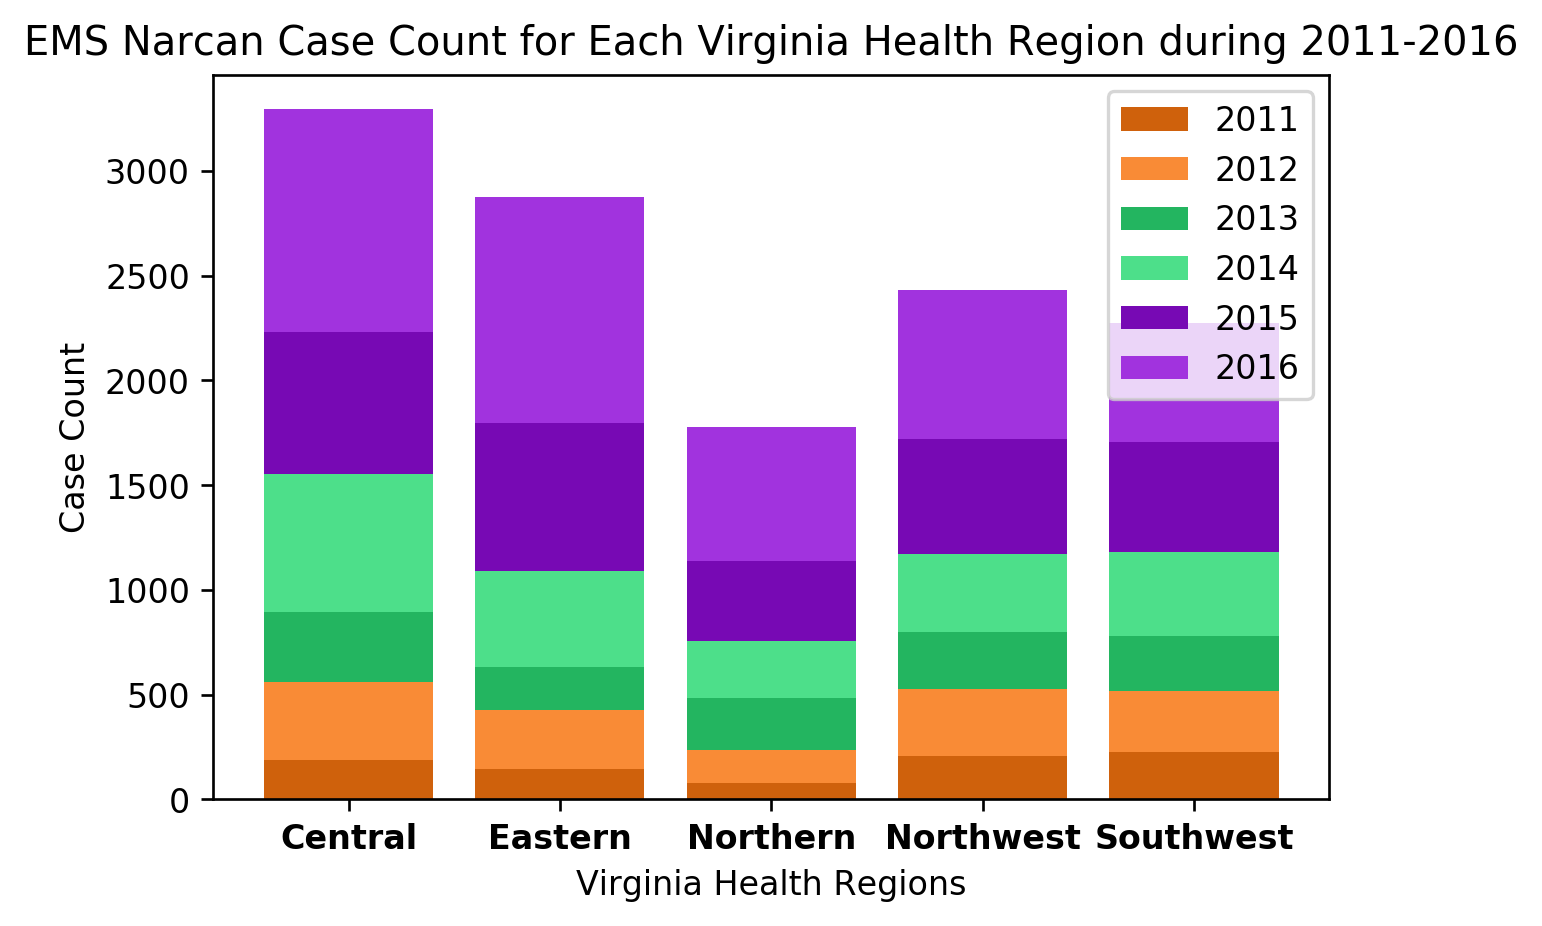

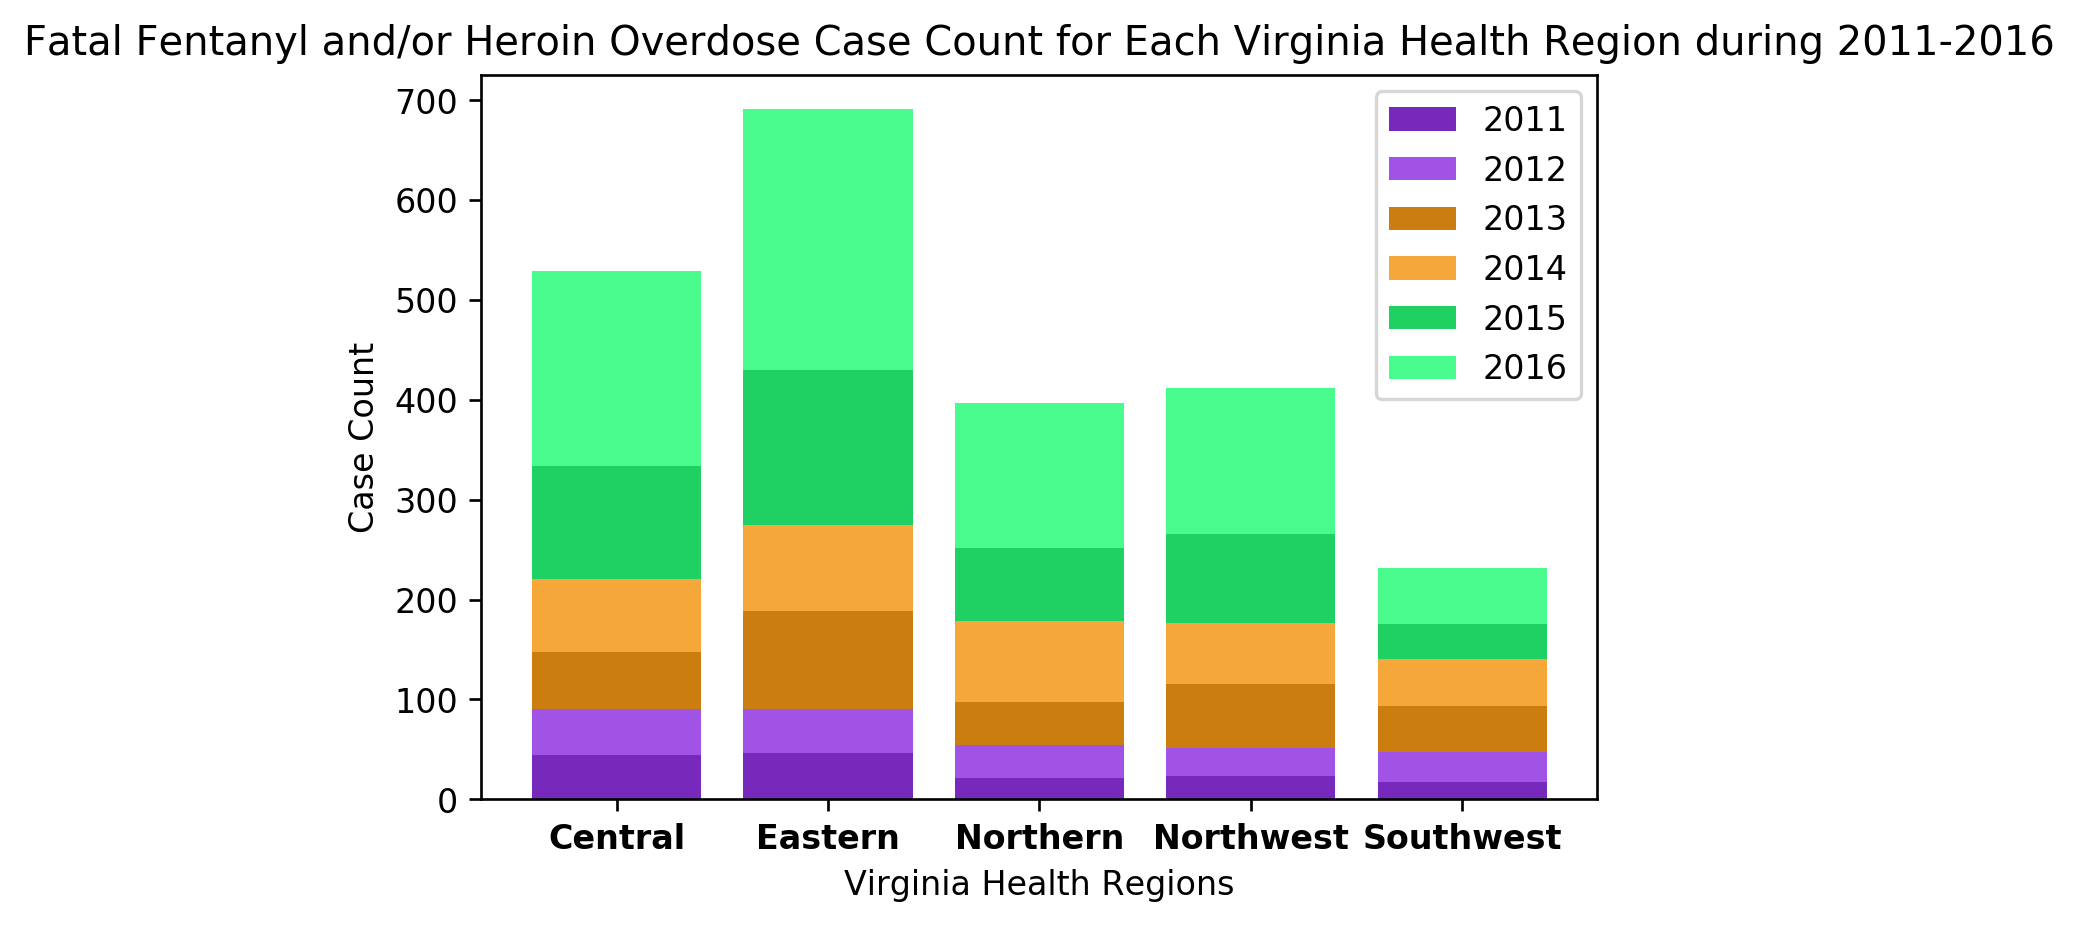

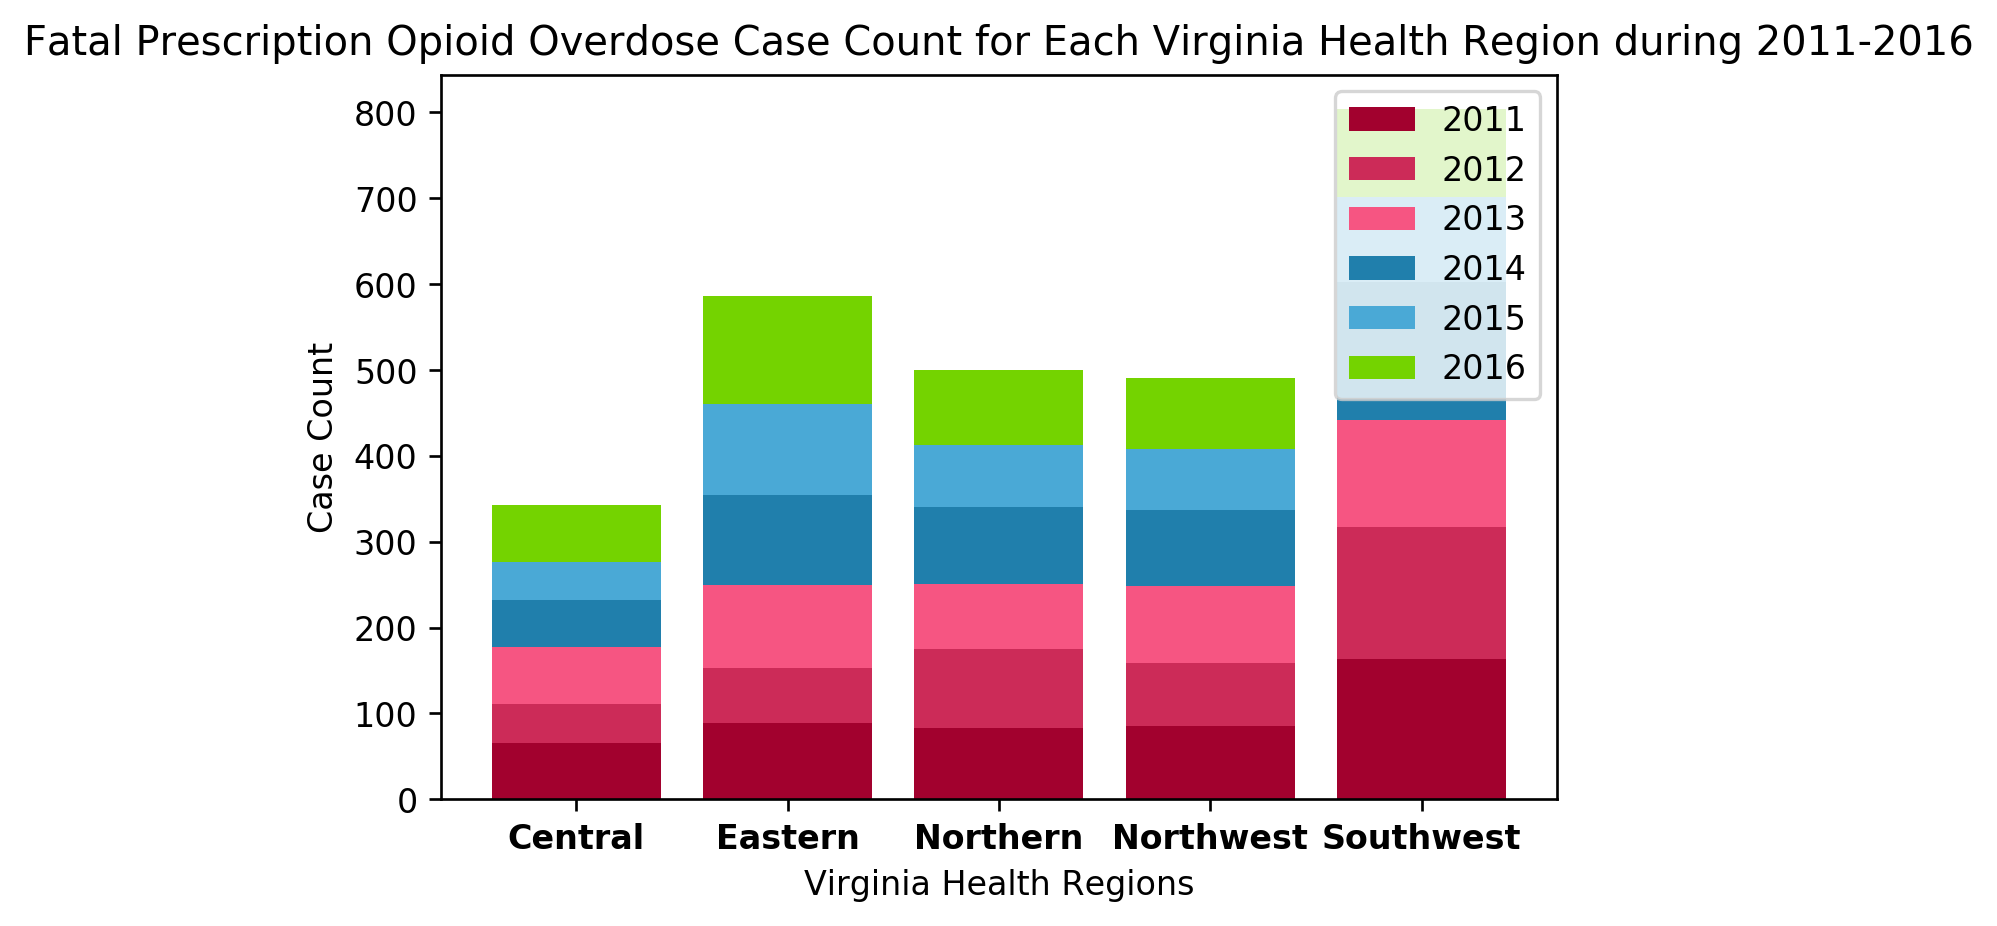

In [25]:
# Case Rate of EMS Narcan
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc
# 1) x -> -> Rate (col: 12) of Virginia Health Region (col: 10)
    #   a) Name: column 10, Case Count: column 11, Rate: column 12
x_names = ['Central', 'Eastern', 'Northern', 'Northwest', 'Southwest']
x_data = sorted(df_plt2[10].unique())
#print("x_data:\n", x_data)
# 2) y -> Case Count (col: 11) of each Year (col: 0)
y_data_names = ["2011", "2012", "2013", "2014", "2015", "2016"]
    #   a) Specify the dataset is df_plt2, Count (col:11), and Type=='EMS Narcan' (col:4)
df_flt0 = (df_plt2[11])[df_plt2[4] == 'EMS Narcan']
    #   b) Extract Rate of each PD each Year into matrix y_data_list[division][year]
y_data_list = []
# Caution! i-->Year; j-->VSPD
for i in range (2011, 2016+1):  # 2011-2016 is Year (col:0)
    df_flt1 = df_flt0[df_plt2[0] == i]
    j_data = []
    for j in range(0, len(x_data)):  # 0~6 is VSPD1~VSPD7 (col:22)
        df_flt2 = df_flt1[df_plt2[10] == x_data[j]]
        rate = int(np.array(df_flt2)[0])
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
#print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
#print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "Virginia Health Regions"
y_label = "Case Count"
title = "EMS Narcan Case Count for Each Virginia Health Region during 2011-2016"
# 5) Print plot
stackedbarplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)


# Case Rate of Fatal Fentanyl and/or Heroin Overdose
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc
# 1) x -> -> Rate (col: 12) of Virginia Health Region (col: 10)
    #   a) Name: column 10, Case Count: column 11, Rate: column 12
x_names = ['Central', 'Eastern', 'Northern', 'Northwest', 'Southwest']
x_data = sorted(df_plt2[10].unique())
#print("x_data:\n", x_data)
# 2) y -> Case Count (col: 11) of each Year (col: 0)
y_data_names = ["2011", "2012", "2013", "2014", "2015", "2016"]
    #   a) Specify the dataset is df_plt2, Count (col:11), and Type=='Fatal Fentanyl and/or Heroin Overdose' (col:4)
df_flt0 = (df_plt2[11])[df_plt2[4] == 'Fatal Fentanyl and/or Heroin Overdose']
    #   b) Extract Rate of each PD each Year into matrix y_data_list[division][year]
y_data_list = []
# Caution! i-->Year; j-->VSPD
for i in range (2011, 2016+1):  # 2011-2016 is Year (col:0)
    df_flt1 = df_flt0[df_plt2[0] == i]
    j_data = []
    for j in range(0, len(x_data)):  # 0~6 is VSPD1~VSPD7 (col:22)
        df_flt2 = df_flt1[df_plt2[10] == x_data[j]]
        rate = int(np.array(df_flt2)[0])
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
#print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
#print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "Virginia Health Regions"
y_label = "Case Count"
title = "Fatal Fentanyl and/or Heroin Overdose Case Count for Each Virginia Health Region during 2011-2016"
# 5) Print plot
stackedbarplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)


# Case Rate of Fatal Prescription Opioid Overdose
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc
# 1) x -> -> Rate (col: 12) of Virginia Health Region (col: 10)
    #   a) Name: column 10, Case Count: column 11, Rate: column 12
x_names = ['Central', 'Eastern', 'Northern', 'Northwest', 'Southwest']
x_data = sorted(df_plt2[10].unique())
#print("x_data:\n", x_data)
# 2) y -> Case Count (col: 11) of each Year (col: 0)
y_data_names = ["2011", "2012", "2013", "2014", "2015", "2016"]
    #   a) Specify the dataset is df_plt2, Count (col:11), and Type=='Fatal Prescription Opioid Overdose' (col:4)
df_flt0 = (df_plt2[11])[df_plt2[4] == 'Fatal Prescription Opioid Overdose']
    #   b) Extract Rate of each PD each Year into matrix y_data_list[division][year]
y_data_list = []
# Caution! i-->Year; j-->VSPD
for i in range (2011, 2016+1):  # 2011-2016 is Year (col:0)
    df_flt1 = df_flt0[df_plt2[0] == i]
    j_data = []
    for j in range(0, len(x_data)):  # 0~6 is VSPD1~VSPD7 (col:22)
        df_flt2 = df_flt1[df_plt2[10] == x_data[j]]
        rate = int(np.array(df_flt2)[0])
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
#print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
#print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "Virginia Health Regions"
y_label = "Case Count"
title = "Fatal Prescription Opioid Overdose Case Count for Each Virginia Health Region during 2011-2016"
# 5) Print plot
stackedbarplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)

x_data:
 ['0-14', '15-24', '25-34', '35-44', '45-54', '55-64', '65+']
y_data:
 ['Diagnosed HIV', 'ED Heroin Overdose', 'ED Opioid Overdose', 'EMS Narcan', 'Fatal Fentanyl and/or Heroin Overdose', 'Fatal Prescription Opioid Overdose']
y_data_list:
 [[0.2, 19.0, 28.0, 14.4, 11.1, 6.1, 1.8], [0.0, 24.9, 49.7, 21.1, 15.8, 9.5, 1.7], [41.6, 170.6, 171.2, 119.2, 108.4, 84.0, 54.4], [1.5, 47.9, 101.4, 65.3, 57.9, 50.6, 30.8], [0.1, 8.2, 23.9, 18.6, 12.5, 6.8, 0.7], [0.1, 4.7, 8.8, 9.7, 9.4, 6.9, 1.5]]
the generated random colors:
 ['#937e50', '#bda87a', '#e7d2a4', '#11fcce', '#3b26f8', '#655022']


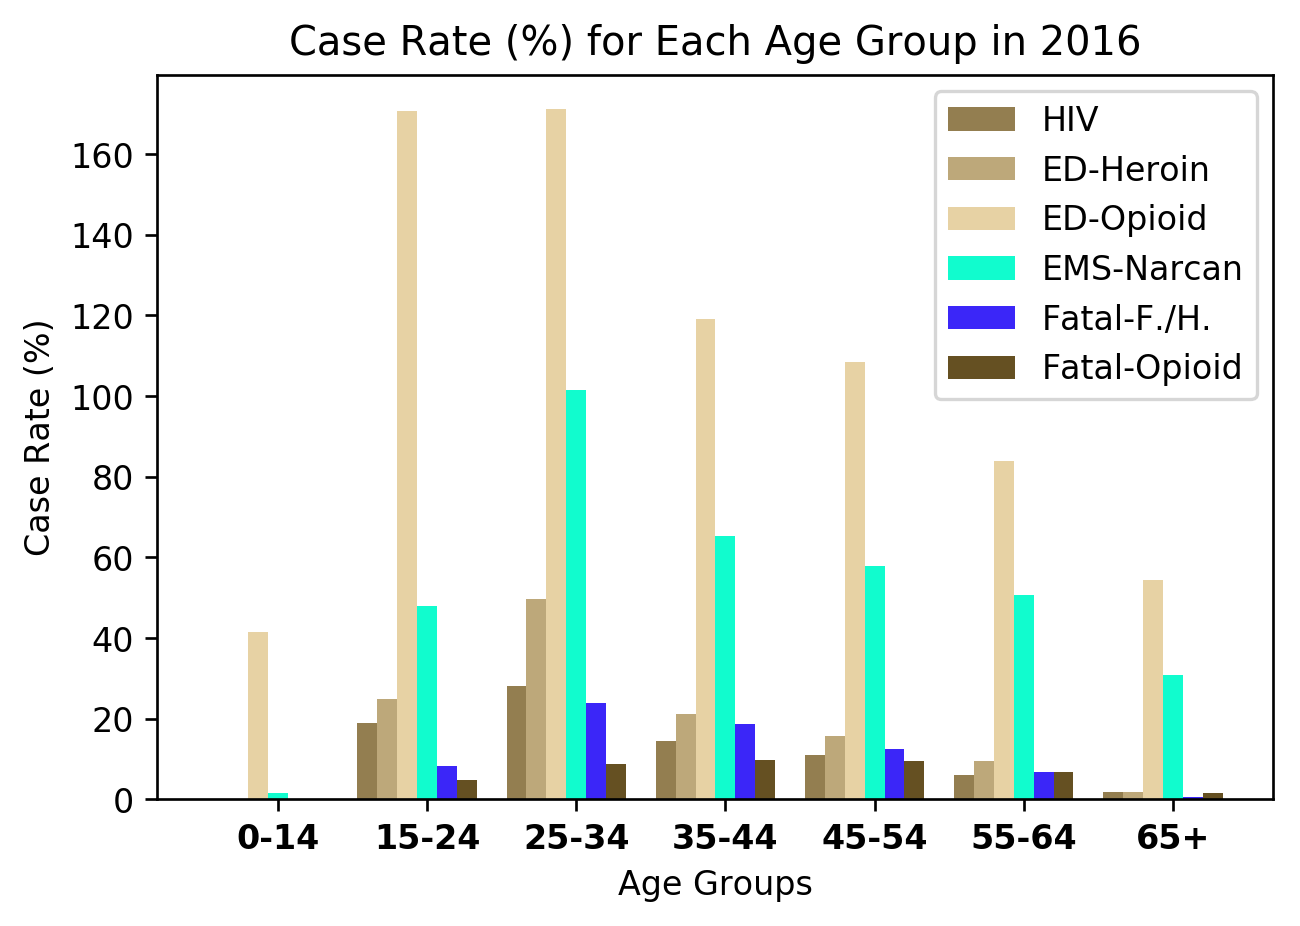

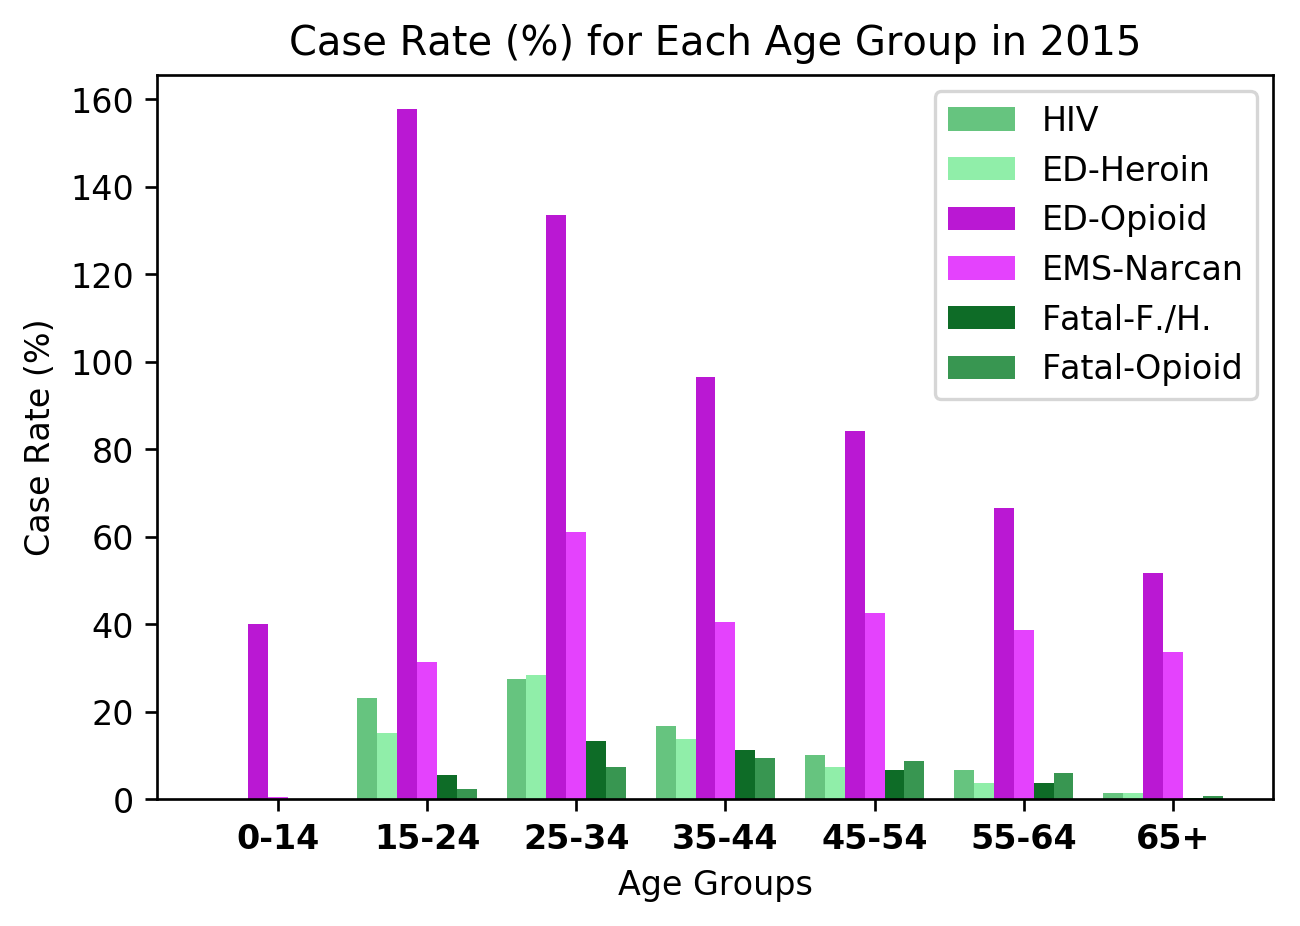

In [26]:
# part4: Case Rate by Age Group (group_bar_plot)
df_plt2 = ds_ag_enc
df_pltf1 = df_plt2[df_plt2[4] != 'Reported Hepatitis C (18-30 year olds)']
df_plt = df_pltf1[df_pltf1[4] != 'Neonatal Abstinance Syndrome']
# In this part, we plot a graph that shows the case count rate of
# "EMS Narcan" in each police division from 2011 to 2017.
# For this purpose, we need the following data:
# 1) x -> Age group (col:5)
    #   a) Name: Virginia State, Case Count: column 27, Rate: column 28
x_names = ['0-14', '15-24', '25-34', '35-44', '45-54', '55-64', '65+',]
x_data = sorted(df_plt[5].unique())
print("x_data:\n", x_data)
# 2) y -> Rate (col: 28) of each Type (col: 4)
y_data_names = ['HIV', 'ED-Heroin', 'ED-Opioid', 'EMS-Narcan', 'Fatal-F./H.', 'Fatal-Opioid']
    #   a) Specify the dataset is df_plt, Rate (col:28), and Year==2016 (col:0)
df_flt0 = df_plt[df_plt[0] == 2016]
df_flt0 = df_flt0.iloc[:, [4,5,28]]
y_data = sorted(df_plt[4].unique())
print("y_data:\n", y_data)
#print("df_flt0:\n", df_flt0)
    #   b) Extract Rate of each Type each Age Group into matrix y_data_list[Age_Group][Type]
y_data_list = []
# Caution! i-->Type; j-->Age_Group
for i in range (0, len(y_data)):  # 0-7 Types (col:4)
    df_flt1 = df_flt0[df_flt0[4] == y_data[i]]
    #print("\nguess it is using data:",df_flt1)
    j_data = []
    for j in range(0, len(x_data)):  # 0~7 is each age group (col:5)
        df_flt2 = df_flt1[df_flt1[5] == x_data[j]]
        rate = np.array(df_flt2[28])[0]
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "Age Groups"
y_label = "Case Rate (%)"
title = "Case Rate (%) for Each Age Group in 2016"
# 5) Print plot
x_data=[0, 1, 2, 3, 4, 5, 6]
groupedbarplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)


# Case Rate in 2015
df_plt2 = ds_ag_enc
df_pltf1 = df_plt2[df_plt2[4] != 'Reported Hepatitis C (18-30 year olds)']
df_plt = df_pltf1[df_pltf1[4] != 'Neonatal Abstinance Syndrome']
# 1) x -> Age group (col:5)
    #   a) Name: Virginia State, Case Count: column 27, Rate: column 28
x_names = ['0-14', '15-24', '25-34', '35-44', '45-54', '55-64', '65+',]
x_data = sorted(df_plt[5].unique())
#print("x_data:\n", x_data)
# 2) y -> Rate (col: 28) of each Type (col: 4)
y_data_names = ['HIV', 'ED-Heroin', 'ED-Opioid', 'EMS-Narcan', 'Fatal-F./H.', 'Fatal-Opioid']
    #   a) Specify the dataset is df_plt, Rate (col:28), and Year==2015 (col:0)
df_flt0 = df_plt[df_plt[0] == 2015]
df_flt0 = df_flt0.iloc[:, [4,5,28]]
y_data = sorted(df_plt[4].unique())
#print("y_data:\n", y_data)
#print("df_flt0:\n", df_flt0)
    #   b) Extract Rate of each Type each Age Group into matrix y_data_list[Age_Group][Type]
y_data_list = []
# Caution! i-->Type; j-->Age_Group
for i in range (0, len(y_data)):  # 0-7 Types (col:4)
    df_flt1 = df_flt0[df_flt0[4] == y_data[i]]
    #print("\nguess it is using data:",df_flt1)
    j_data = []
    for j in range(0, len(x_data)):  # 0~7 is each age group (col:5)
        df_flt2 = df_flt1[df_flt1[5] == x_data[j]]
        rate = np.array(df_flt2[28])[0]
        j_data.append(rate)
    y_data_list.append(j_data)
    #   c) y_data_list is ready
#print("y_data_list:\n", y_data_list)
# 3) Generate random color
    # i = count(y_data)
ydl_count = len(y_data_list)
colors = random_colors(ydl_count)
#print("the generated random colors:\n", colors)
# 4) Specify the title and labels
x_label = "Age Groups"
y_label = "Case Rate (%)"
title = "Case Rate (%) for Each Age Group in 2015"
# 5) Print plot
x_data=[0, 1, 2, 3, 4, 5, 6]
groupedbarplot(x_data, y_data_list, colors, x_names, y_data_names, x_label, y_label, title)

In [27]:
# part5: Case Rates by County (choropleth_map)
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc

# In this part, we plot a choropleth map that shows the Death Rate of
# "Fetal Fentanyl and/or Heroin Overdose" in each county in 2016.
# For this purpose, we need the following data:

title = "Fetal Fentanyl/Heroin Overdose Death Rate by County in 2016"
# 1. Specify the year
df_flt0 = df_plt2[df_plt2[0] == 2016]
#print(df_flt0.shape)
# 2. Specify the Type
df_flt1 = df_flt0[df_flt0[4] == 'Fatal Fentanyl and/or Heroin Overdose']
#print(df_flt1.shape)

# 3. Find the correspoding column numbers
x_data = df_flt1.iloc[:,1].tolist()
#print("x_data:\n", x_data)
y_data_list = df_flt1.iloc[:,6].tolist()
#print("y_data_list:\n", y_data_list)

# 4. Print the map
cho_fig1 = choropleth_map(x_data, y_data_list, title)
pltly.iplot(cho_fig1, filename='choropleth_virginia2016')

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




In [28]:
# Case Rate of Fatal Prescription Opioid Overdose
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc

title = "Fatal Prescription Opioid Overdose Death Rate by County in 2016"
# 1. Specify the year and the Type
df_flt0 = df_plt2[df_plt2[0] == 2016]
df_flt1 = df_flt0[df_flt0[4] == 'Fatal Prescription Opioid Overdose']
# 2. Find the correspoding column numbers
x_data = df_flt1.iloc[:,1].tolist()
y_data_list = df_flt1.iloc[:,6].tolist()
# 3. Print the map
cho_fig1 = choropleth_map(x_data, y_data_list, title)
pltly.iplot(cho_fig1, filename='choropleth_virginia2016')

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




In [29]:
# Case Rate of Neonatal Abstinance Syndrome
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc

title = "Neonatal Abstinance Syndrome Case Rate by County in 2016"
# 1. Specify the year and the Type
df_flt0 = df_plt2[df_plt2[0] == 2016]
df_flt1 = df_flt0[df_flt0[4] == 'Neonatal Abstinance Syndrome']
# 2. Find the correspoding column numbers
x_data = df_flt1.iloc[:,1].tolist()
y_data_list = df_flt1.iloc[:,6].tolist()
# 3. Print the map
cho_fig1 = choropleth_map(x_data, y_data_list, title)
pltly.iplot(cho_fig1, filename='choropleth_virginia2016')

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




In [30]:
# Case Rate of ED Heroin Overdose
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc

title = "ED Heroin Overdose Case Rate by County in 2017"
# 1. Specify the year and the Type
df_flt0 = df_plt2[df_plt2[0] == 2017]
df_flt1 = df_flt0[df_flt0[4] == 'ED Heroin Overdose']
# 2. Find the correspoding column numbers
x_data = df_flt1.iloc[:,1].tolist()
y_data_list = df_flt1.iloc[:,6].tolist()
# 3. Print the map
cho_fig1 = choropleth_map(x_data, y_data_list, title)
pltly.iplot(cho_fig1, filename='choropleth_virginia2017')

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




In [31]:
# Case Rate of Reported Hepatitis C (18-30 year olds)
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc

title = "Reported Hepatitis C (18-30 year olds) Case Rate by County in 2017"
# 1. Specify the year and the Type
df_flt0 = df_plt2[df_plt2[0] == 2017]
df_flt1 = df_flt0[df_flt0[4] == 'Reported Hepatitis C (18-30 year olds)']
# 2. Find the correspoding column numbers
x_data = df_flt1.iloc[:,1].tolist()
y_data_list = df_flt1.iloc[:,6].tolist()
# 3. Print the map
cho_fig1 = choropleth_map(x_data, y_data_list, title)
pltly.iplot(cho_fig1, filename='choropleth_virginia2017')

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




In [32]:
"""# try predictions
df_plt1 = ds_ag_enc
df_plt2 = ds_s_enc
print(df_plt2.shape)
# In this demo, we plot a graph that shows the case count of
# "Fetal Fentanyl and/or Heroin Overdose" in each police division from 2011 to 2017.
# For this purpose, we need the following data:

df_flt0 = df_plt2[df_plt2[0] == 2016]
print(df_flt0.shape)
df_flt1 = df_flt0[df_flt0[4] == 'Fatal Fentanyl and/or Heroin Overdose']
print(df_flt1.shape)
print(df_flt1)
x_data = df_flt1.iloc[:,1].tolist()
#print("x_data:\n", x_data)
y_data_list = df_flt1.iloc[:,6].tolist()
#y_data_list = list(map(int, y_data))
print("y_data_list:\n", y_data_list)"""

'# try predictions\ndf_plt1 = ds_ag_enc\ndf_plt2 = ds_s_enc\nprint(df_plt2.shape)\n# In this demo, we plot a graph that shows the case count of\n# "Fetal Fentanyl and/or Heroin Overdose" in each police division from 2011 to 2017.\n# For this purpose, we need the following data:\n\ndf_flt0 = df_plt2[df_plt2[0] == 2016]\nprint(df_flt0.shape)\ndf_flt1 = df_flt0[df_flt0[4] == \'Fatal Fentanyl and/or Heroin Overdose\']\nprint(df_flt1.shape)\nprint(df_flt1)\nx_data = df_flt1.iloc[:,1].tolist()\n#print("x_data:\n", x_data)\ny_data_list = df_flt1.iloc[:,6].tolist()\n#y_data_list = list(map(int, y_data))\nprint("y_data_list:\n", y_data_list)'